In [11]:
import h5py
import matplotlib.pyplot as plt
import numpy as np
import optuna

with h5py.File('data/assignmentImageDenoising_microscopy.mat', 'r') as f:
    print("Keys in the loaded data:")
    print(list(f.keys()))
    data = {k: np.array(v) for k, v in f.items()}

Keys in the loaded data:
['microscopyImageNoisyScale350sigma0point06', 'microscopyImageOrig']


In [12]:

image_noiseless = data['microscopyImageOrig']
image_noisy = data['microscopyImageNoisyScale350sigma0point06']


print(f"Noiseless image shape: {image_noiseless.shape}")
print(f"Noisy image shape: {image_noisy.shape}")
print(f"Image data type: {image_noiseless.dtype}")
print(f"Noiseless image range: [{np.min(image_noiseless):.3f}, {np.max(image_noiseless):.3f}]")
print(f"Noisy image range: [{np.min(image_noisy):.3f}, {np.max(image_noisy):.3f}]")

Noiseless image shape: (3, 528, 393)
Noisy image shape: (3, 528, 393)
Image data type: uint8
Noiseless image range: [10.000, 255.000]
Noisy image range: [0.000, 255.000]


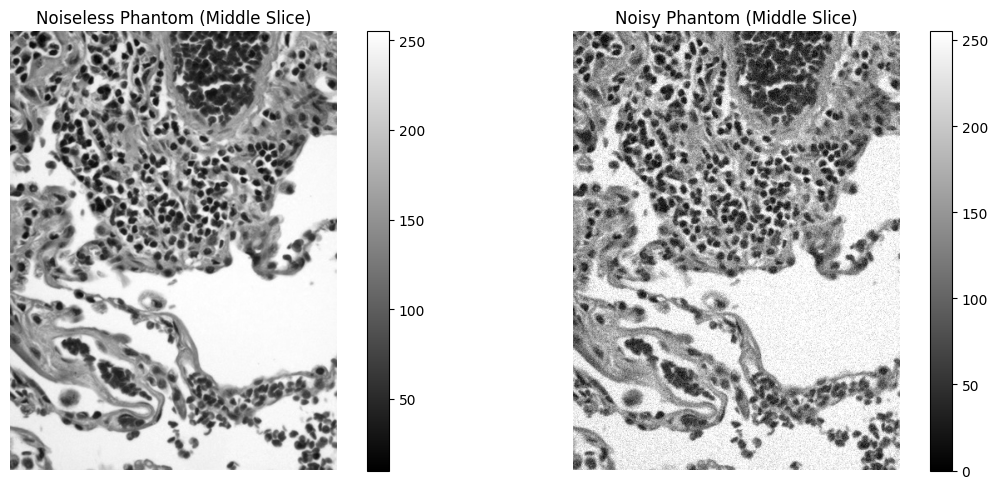

In [13]:
z_mid = image_noiseless.shape[0] // 2

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_noiseless[z_mid, :, :], cmap='gray')
plt.title('Noiseless Phantom (Middle Slice)')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_noisy[z_mid, :, :], cmap='gray')
plt.title('Noisy Phantom (Middle Slice)')
plt.colorbar()
plt.axis('off')

plt.tight_layout()
plt.show()


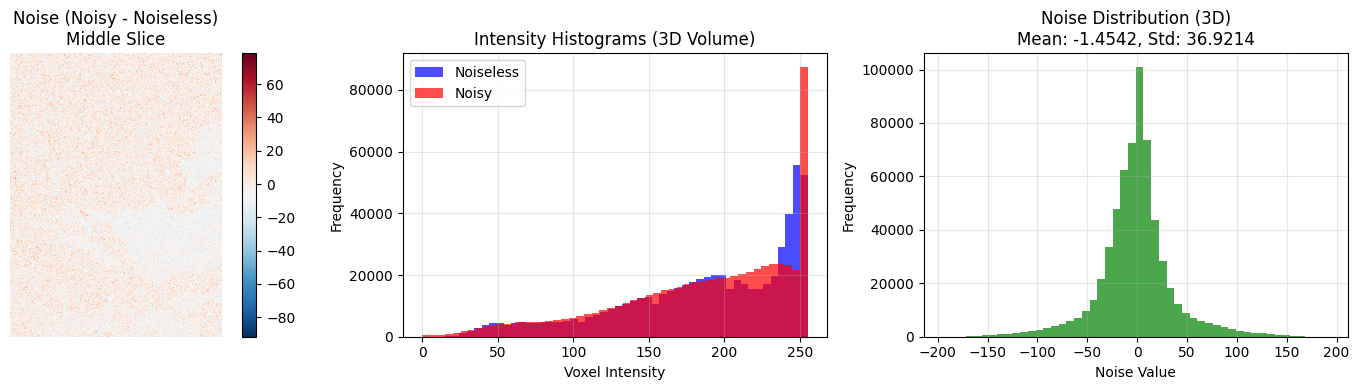

Summary Statistics (3D):
Volume size: (3, 528, 393)
Noise standard deviation: 36.9214
Noise mean: -1.4542
Signal-to-Noise Ratio (SNR): 3.86 dB


In [14]:
noise = image_noisy - image_noiseless
noise_std = np.std(noise)
noise_mean = np.mean(noise)

z_mid = image_noiseless.shape[0] // 2

plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.imshow(noise[z_mid, :, :], cmap='RdBu_r')
plt.title('Noise (Noisy - Noiseless)\nMiddle Slice')
plt.colorbar()
plt.axis('off')

plt.subplot(1, 3, 2)
plt.hist(image_noiseless.flatten(), bins=50, alpha=0.7,
         label='Noiseless', color='blue')
plt.hist(image_noisy.flatten(), bins=50, alpha=0.7,
         label='Noisy', color='red')
plt.title('Intensity Histograms (3D Volume)')
plt.xlabel('Voxel Intensity')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.hist(noise.flatten(), bins=50, alpha=0.7, color='green')
plt.title(f'Noise Distribution (3D)\nMean: {noise_mean:.4f}, Std: {noise_std:.4f}')
plt.xlabel('Noise Value')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Summary Statistics (3D):")
print(f"Volume size: {image_noiseless.shape}")
print(f"Noise standard deviation: {noise_std:.4f}")
print(f"Noise mean: {noise_mean:.4f}")

snr = 20 * np.log10(np.std(image_noiseless) / noise_std)
print(f"Signal-to-Noise Ratio (SNR): {snr:.2f} dB")


# Bayesian Denoising with MRF Priors


In [15]:
import numpy as np
from scipy.ndimage import shift
import time

def circshift_3d(image, shift_vector):
    """
    Circular shift for 3D spatial data with channels
    image: (Z, Y, X, C) or (Y, X, C)
    shift_vector: (dz, dy, dx)
    """
    shifted = np.roll(image, shift_vector[0], axis=0)
    shifted = np.roll(shifted, shift_vector[1], axis=1)
    shifted = np.roll(shifted, shift_vector[2], axis=2)
    return shifted


def compute_rrmse(A, B):
    """
    Compute Relative Root Mean Squared Error (RRMSE)
    RRMSE(A,B) = sqrt(sum((A-B)^2) / sum(A^2))
    """
    numerator = np.sum((A - B) ** 2)
    denominator = np.sum(A ** 2)
    return np.sqrt(numerator / denominator)

def vector_l2_squared_prior(u):
    """
    g_A(u) = ||u||_2^2
    """
    return np.sum(u**2, axis=-1)

def vector_l2_squared_prior_gradient(u):
    """
    ∇g_A(u) = 2u
    """
    return 2 * u

def vector_l2_prior(u, eps=1e-8):
    """
    g_B(u) = ||u||_2
    """
    return np.sqrt(np.sum(u**2, axis=-1) + eps)

def vector_l2_prior_gradient(u, eps=1e-8):
    """
    ∇g_B(u) = u / ||u||_2
    """
    norm_u = np.sqrt(np.sum(u**2, axis=-1, keepdims=True) + eps)
    return u / norm_u

def vector_huber_prior(u, gamma):
    """
    Vector Huber prior
    """
    norm_u = np.linalg.norm(u, axis=-1)
    return np.where(
        norm_u <= gamma,
        0.5 * norm_u**2,
        gamma * norm_u - 0.5 * gamma**2
    )

def vector_huber_prior_gradient(u, gamma, eps=1e-8):
    """
    Gradient of vector Huber prior
    """
    norm_u = np.linalg.norm(u, axis=-1, keepdims=True) + eps
    return np.where(
        norm_u <= gamma,
        u,
        gamma * u / norm_u
    )

print("Prior functions and utility functions defined successfully!")

Prior functions and utility functions defined successfully!


In [16]:
def compute_neighbor_differences(x):
    """
    Compute differences between each voxel and its 6 neighbors
    x: (Z, Y, X, C)
    Returns list of difference arrays
    """
    neighbors = [
        circshift_3d(x, [ 1,  0,  0]),  
        circshift_3d(x, [-1,  0,  0]),  
        circshift_3d(x, [ 0,  1,  0]),  
        circshift_3d(x, [ 0, -1,  0]),  
        circshift_3d(x, [ 0,  0,  1]),  
        circshift_3d(x, [ 0,  0, -1])   
    ]

    return [x - nbr for nbr in neighbors]

def compute_mrf_energy(x, prior_func, gamma=None):
    """
    Compute MRF prior energy for 3D vector-valued data
    """
    differences = compute_neighbor_differences(x)
    energy = 0.0

    for diff in differences:
        if gamma is not None:
            energy += np.sum(prior_func(diff, gamma))
        else:
            energy += np.sum(prior_func(diff))

    return energy

def compute_mrf_gradient(x, prior_gradient_func, gamma=None):
    """
    Compute gradient of MRF prior energy for 3D vector-valued data
    """
    differences = compute_neighbor_differences(x)
    gradient = np.zeros_like(x)

    for diff in differences:
        if gamma is not None:
            gradient += prior_gradient_func(diff, gamma)
        else:
            gradient += prior_gradient_func(diff)

    return gradient

print("MRF energy and gradient functions defined successfully!")

MRF energy and gradient functions defined successfully!


In [22]:
def bayesian_denoising(noisy_image, alpha, prior_type='A', gamma=1.0, 
                      max_iterations=100, tolerance=1e-6, sigma=1.0):
    """
    Bayesian MAP denoising for 3D vector-valued microscopy data
    using simulated annealing and vector-valued MRF priors
    
    prior_type:
        'A' -> squared L2 norm
        'B' -> L2 norm
        'C' -> Huber-regularized L1 norm
    """
    
    x = noisy_image.copy()
    objective_values = []
    
    if prior_type == 'A':
        prior_func = vector_l2_squared_prior
        prior_grad_func = vector_l2_squared_prior_gradient
        use_gamma = False
    elif prior_type == 'B':
        prior_func = vector_l2_prior
        prior_grad_func = vector_l2_prior_gradient
        use_gamma = False
    elif prior_type == 'C':
        prior_func = vector_huber_prior
        prior_grad_func = vector_huber_prior_gradient
        use_gamma = True
    else:
        raise ValueError("prior_type must be 'A', 'B', or 'C'")
    
    step_size = 0.05
    temperature = 1.0
    cooling_rate = 0.975

    for iteration in range(max_iterations):

        likelihood_gradient = (1 / sigma**2) * (noisy_image - x)
        if use_gamma:
            prior_gradient = compute_mrf_gradient(x, prior_grad_func, gamma)
        else:
            prior_gradient = compute_mrf_gradient(x, prior_grad_func)
        
        total_gradient = (1 - alpha) * likelihood_gradient - alpha * prior_gradient
        
        likelihood_energy = -0.5 / (sigma**2) * np.sum((x - noisy_image)**2)
        if use_gamma:
            prior_energy = -compute_mrf_energy(x, prior_func, gamma)
        else:
            prior_energy = -compute_mrf_energy(x, prior_func)
        
        current_objective = (1 - alpha) * likelihood_energy + alpha * prior_energy
        objective_values.append(current_objective)
        
        x_new, new_objective, accepted = simulated_annealing_step(x, total_gradient, current_objective, noisy_image, alpha, prior_func, gamma if use_gamma else None, sigma, step_size, temperature)
        
        x = x_new
        temperature *= cooling_rate
        
        if iteration > 0:
            if abs(objective_values[-1] - objective_values[-2]) < tolerance and temperature < 1e-3:
                print(f"Converged after {iteration + 1} iterations")
                break
        
        if (iteration + 1) % 10 == 0:
            print(
                f"Iteration {iteration + 1}: "
                f"Objective = {current_objective:.6f}, "
                f"Temperature = {temperature:.6f}"
            )
    
    return x, objective_values

def simulated_annealing_step(x, gradient, current_obj,
                             noisy_image, alpha,
                             prior_func, gamma,
                             sigma, step, temperature):
    """
    One simulated annealing update step
    """

    x_trial = x + step * gradient

    likelihood_energy = -0.5 / (sigma**2) * np.sum((x_trial - noisy_image)**2)

    if gamma is not None:
        prior_energy = -compute_mrf_energy(x_trial, prior_func, gamma)
    else:
        prior_energy = -compute_mrf_energy(x_trial, prior_func)

    trial_objective = (1 - alpha) * likelihood_energy + alpha * prior_energy

    delta_obj = trial_objective - current_obj

    if delta_obj >= 0:
        accept = True
    else:
        accept = np.random.rand() < np.exp(delta_obj / temperature)

    if accept:
        return x_trial, trial_objective, True
    else:
        return x, current_obj, False

print("Bayesian denoising algorithm implemented successfully!")

Bayesian denoising algorithm implemented successfully!


## Testing the Denoising Algorithm

Now let's test our Bayesian denoising algorithm with different MRF priors and find optimal parameters.

In [18]:
def objective_A(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='A',
        max_iterations=100,
        tolerance=1e-6
    )

    return compute_rrmse(image_noiseless, denoised)


study_A = optuna.create_study(direction="minimize")
study_A.optimize(objective_A, n_trials=200)

best_alpha_A = study_A.best_params["alpha"]


[I 2026-02-06 22:10:55,459] A new study created in memory with name: no-name-a5f65c9c-aafe-4a95-99c7-66d11a9bf8a9


Iteration 10: Objective = -19369441.043645, Temperature = 0.776330
Iteration 20: Objective = -19162574.505958, Temperature = 0.602688
Iteration 30: Objective = -19103526.473916, Temperature = 0.467884
Iteration 40: Objective = -19084954.196988, Temperature = 0.363232
Iteration 50: Objective = -19078888.404644, Temperature = 0.281988
Iteration 60: Objective = -19076881.524179, Temperature = 0.218916
Iteration 70: Objective = -19076213.190947, Temperature = 0.169951
Iteration 80: Objective = -19075991.429937, Temperature = 0.131938
Iteration 90: Objective = -19075921.412052, Temperature = 0.102427


[I 2026-02-06 22:11:13,820] Trial 0 finished with value: 3.626214642615453 and parameters: {'alpha': 0.003862116944356092}. Best is trial 0 with value: 3.626214642615453.


Iteration 100: Objective = -19075907.211106, Temperature = 0.079517
Iteration 10: Objective = -293913190.805884, Temperature = 0.776330
Iteration 20: Objective = -271800890.772559, Temperature = 0.602688
Iteration 30: Objective = -269331944.230864, Temperature = 0.467884
Iteration 40: Objective = -268743387.075403, Temperature = 0.363232
Iteration 50: Objective = -268552156.791149, Temperature = 0.281988
Iteration 60: Objective = -268482774.612979, Temperature = 0.218916
Iteration 70: Objective = -268456328.377756, Temperature = 0.169951
Iteration 80: Objective = -268446065.161498, Temperature = 0.131938
Iteration 90: Objective = -268441950.986719, Temperature = 0.102427


[I 2026-02-06 22:11:27,395] Trial 1 finished with value: 2.677937890639794 and parameters: {'alpha': 0.28928790157457734}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -268440285.556465, Temperature = 0.079517
Iteration 10: Objective = -168919321.442894, Temperature = 0.776330
Iteration 20: Objective = -130627180.227275, Temperature = 0.602688
Iteration 30: Objective = -118520469.019083, Temperature = 0.467884
Iteration 40: Objective = -113148719.944525, Temperature = 0.363232
Iteration 50: Objective = -110376894.945455, Temperature = 0.281988
Iteration 60: Objective = -108805859.199838, Temperature = 0.218916
Iteration 70: Objective = -107856238.487575, Temperature = 0.169951
Iteration 80: Objective = -107254763.947669, Temperature = 0.131938
Iteration 90: Objective = -106860066.288067, Temperature = 0.102427


[I 2026-02-06 22:11:38,006] Trial 2 finished with value: 3.361691571037309 and parameters: {'alpha': 0.8284739399891176}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -106593899.210584, Temperature = 0.079517
Iteration 10: Objective = -107237295.097291, Temperature = 0.776330
Iteration 20: Objective = -101661570.332553, Temperature = 0.602688
Iteration 30: Objective = -100424303.895833, Temperature = 0.467884
Iteration 40: Objective = -100105872.483973, Temperature = 0.363232
Iteration 50: Objective = -100019072.850290, Temperature = 0.281988
Iteration 60: Objective = -99994748.314600, Temperature = 0.218916
Iteration 70: Objective = -99987815.059147, Temperature = 0.169951
Iteration 80: Objective = -99985817.052681, Temperature = 0.131938
Iteration 90: Objective = -99985248.750916, Temperature = 0.102427


[I 2026-02-06 22:11:48,345] Trial 3 finished with value: 3.326716571765574 and parameters: {'alpha': 0.026004496479656476}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -99985102.625885, Temperature = 0.079517
Iteration 10: Objective = -284934743.598004, Temperature = 0.776330
Iteration 20: Objective = -265160762.295644, Temperature = 0.602688
Iteration 30: Objective = -262347751.300099, Temperature = 0.467884
Iteration 40: Objective = -261519168.992786, Temperature = 0.363232
Iteration 50: Objective = -261219534.247141, Temperature = 0.281988
Iteration 60: Objective = -261102409.348914, Temperature = 0.218916
Iteration 70: Objective = -261054701.874529, Temperature = 0.169951
Iteration 80: Objective = -261034755.791708, Temperature = 0.131938
Iteration 90: Objective = -261026205.069633, Temperature = 0.102427


[I 2026-02-06 22:12:06,053] Trial 4 finished with value: 2.708009017105786 and parameters: {'alpha': 0.3641840681037513}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -261022534.014411, Temperature = 0.079517
Iteration 10: Objective = -44794576.477251, Temperature = 0.776330
Iteration 20: Objective = -43726411.800317, Temperature = 0.602688
Iteration 30: Objective = -43442898.616330, Temperature = 0.467884
Iteration 40: Objective = -43358953.457008, Temperature = 0.363232
Iteration 50: Objective = -43333050.480420, Temperature = 0.281988
Iteration 60: Objective = -43324930.699472, Temperature = 0.218916
Iteration 70: Objective = -43322367.356170, Temperature = 0.169951
Iteration 80: Objective = -43321557.824333, Temperature = 0.131938
Iteration 90: Objective = -43321307.316706, Temperature = 0.102427


[I 2026-02-06 22:12:23,770] Trial 5 finished with value: 3.537860120131182 and parameters: {'alpha': 0.009400915231335178}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -43321242.774489, Temperature = 0.079517
Iteration 10: Objective = -718349.777058, Temperature = 0.776330
Iteration 20: Objective = -718058.113544, Temperature = 0.602688
Iteration 30: Objective = -717970.326066, Temperature = 0.467884
Iteration 40: Objective = -717941.402640, Temperature = 0.363232
Iteration 50: Objective = -717931.582022, Temperature = 0.281988
Iteration 60: Objective = -717928.309979, Temperature = 0.218916
Iteration 70: Objective = -717927.522488, Temperature = 0.169951
Iteration 80: Objective = -717927.438121, Temperature = 0.131938
Iteration 90: Objective = -717927.440227, Temperature = 0.102427


[I 2026-02-06 22:12:51,735] Trial 6 finished with value: 3.6923404099603547 and parameters: {'alpha': 0.0001382611631601492}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -717927.440746, Temperature = 0.079517
Iteration 10: Objective = -25158681.086602, Temperature = 0.776330
Iteration 20: Objective = -24812413.554124, Temperature = 0.602688
Iteration 30: Objective = -24715196.071250, Temperature = 0.467884
Iteration 40: Objective = -24685039.372043, Temperature = 0.363232
Iteration 50: Objective = -24675319.527063, Temperature = 0.281988
Iteration 60: Objective = -24672144.834101, Temperature = 0.218916
Iteration 70: Objective = -24671100.509767, Temperature = 0.169951
Iteration 80: Objective = -24670758.007839, Temperature = 0.131938
Iteration 90: Objective = -24670649.933721, Temperature = 0.102427


[I 2026-02-06 22:13:19,991] Trial 7 finished with value: 3.605930961086411 and parameters: {'alpha': 0.005073633688433996}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -24670627.671588, Temperature = 0.079517
Iteration 10: Objective = -284576159.440263, Temperature = 0.776330
Iteration 20: Objective = -264850986.221391, Temperature = 0.602688
Iteration 30: Objective = -262020751.988500, Temperature = 0.467884
Iteration 40: Objective = -261183116.839899, Temperature = 0.363232
Iteration 50: Objective = -260879463.890820, Temperature = 0.281988
Iteration 60: Objective = -260760497.242700, Temperature = 0.218916
Iteration 70: Objective = -260711957.655298, Temperature = 0.169951
Iteration 80: Objective = -260691583.771188, Temperature = 0.131938
Iteration 90: Objective = -260682886.787281, Temperature = 0.102427


[I 2026-02-06 22:13:31,406] Trial 8 finished with value: 2.709333888403637 and parameters: {'alpha': 0.36649111424997766}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -260679104.657677, Temperature = 0.079517
Iteration 10: Objective = -673158.814376, Temperature = 0.776330
Iteration 20: Objective = -672902.676295, Temperature = 0.602688
Iteration 30: Objective = -672825.564356, Temperature = 0.467884
Iteration 40: Objective = -672800.184556, Temperature = 0.363232
Iteration 50: Objective = -672791.540236, Temperature = 0.281988
Iteration 60: Objective = -672788.647477, Temperature = 0.218916
Iteration 70: Objective = -672788.030274, Temperature = 0.169951
Iteration 80: Objective = -672787.958483, Temperature = 0.131938
Iteration 90: Objective = -672787.942698, Temperature = 0.102427


[I 2026-02-06 22:13:40,943] Trial 9 finished with value: 3.6925023110381594 and parameters: {'alpha': 0.00012955241461442443}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -672787.943247, Temperature = 0.079517
Iteration 10: Objective = -189084063.761173, Temperature = 0.776330
Iteration 20: Objective = -174054077.563144, Temperature = 0.602688
Iteration 30: Objective = -171434338.388241, Temperature = 0.467884
Iteration 40: Objective = -170867545.086468, Temperature = 0.363232
Iteration 50: Objective = -170733992.328300, Temperature = 0.281988
Iteration 60: Objective = -170701109.720898, Temperature = 0.218916
Iteration 70: Objective = -170692753.809678, Temperature = 0.169951
Iteration 80: Objective = -170690582.572209, Temperature = 0.131938
Iteration 90: Objective = -170690016.676840, Temperature = 0.102427


[I 2026-02-06 22:13:51,970] Trial 10 finished with value: 3.05435408980846 and parameters: {'alpha': 0.059121455922387725}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -170689892.914110, Temperature = 0.079517
Iteration 10: Objective = -281630013.360234, Temperature = 0.776330
Iteration 20: Objective = -255921143.128933, Temperature = 0.602688
Iteration 30: Objective = -252937820.736343, Temperature = 0.467884
Iteration 40: Objective = -252434803.428323, Temperature = 0.363232
Iteration 50: Objective = -252327754.783998, Temperature = 0.281988
Iteration 60: Objective = -252299854.213471, Temperature = 0.218916
Iteration 70: Objective = -252291446.279964, Temperature = 0.169951
Iteration 80: Objective = -252288678.343687, Temperature = 0.131938
Iteration 90: Objective = -252287720.871338, Temperature = 0.102427


[I 2026-02-06 22:14:03,216] Trial 11 finished with value: 2.7344820411843904 and parameters: {'alpha': 0.15764099013277688}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -252287424.372632, Temperature = 0.079517
Iteration 10: Objective = -270898385.706998, Temperature = 0.776330
Iteration 20: Objective = -245864550.228636, Temperature = 0.602688
Iteration 30: Objective = -242738854.357912, Temperature = 0.467884
Iteration 40: Objective = -242199596.330979, Temperature = 0.363232
Iteration 50: Objective = -242089149.749322, Temperature = 0.281988
Iteration 60: Objective = -242062710.183658, Temperature = 0.218916
Iteration 70: Objective = -242055437.789756, Temperature = 0.169951
Iteration 80: Objective = -242053215.024231, Temperature = 0.131938
Iteration 90: Objective = -242052494.433138, Temperature = 0.102427


[I 2026-02-06 22:14:18,485] Trial 12 finished with value: 2.773903739484888 and parameters: {'alpha': 0.13448140369292474}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -242052241.886779, Temperature = 0.079517
Iteration 10: Objective = -224840899.986691, Temperature = 0.776330
Iteration 20: Objective = -159387801.838700, Temperature = 0.602688
Iteration 30: Objective = -146818192.941455, Temperature = 0.467884
Iteration 40: Objective = -146818192.941455, Temperature = 0.363232
Iteration 50: Objective = -146818192.941455, Temperature = 0.281988
Iteration 60: Objective = -146818192.941455, Temperature = 0.218916
Iteration 70: Objective = -146818192.941455, Temperature = 0.169951
Iteration 80: Objective = -146818192.941455, Temperature = 0.131938
Iteration 90: Objective = -146818192.941455, Temperature = 0.102427


[I 2026-02-06 22:14:31,678] Trial 13 finished with value: 3.2883026878655 and parameters: {'alpha': 0.9154563284602899}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -146818192.941455, Temperature = 0.079517
Iteration 10: Objective = -146045881.988113, Temperature = 0.776330
Iteration 20: Objective = -136346453.709791, Temperature = 0.602688
Iteration 30: Objective = -134422548.220472, Temperature = 0.467884
Iteration 40: Objective = -133966306.678787, Temperature = 0.363232
Iteration 50: Objective = -133850148.896475, Temperature = 0.281988
Iteration 60: Objective = -133819478.184498, Temperature = 0.218916
Iteration 70: Objective = -133811192.712796, Temperature = 0.169951
Iteration 80: Objective = -133808917.615850, Temperature = 0.131938
Iteration 90: Objective = -133808307.461238, Temperature = 0.102427


[I 2026-02-06 22:14:43,389] Trial 14 finished with value: 3.197583835764515 and parameters: {'alpha': 0.03946532661310163}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -133808152.948048, Temperature = 0.079517
Iteration 10: Objective = -8098451.747866, Temperature = 0.776330
Iteration 20: Objective = -8061739.012717, Temperature = 0.602688
Iteration 30: Objective = -8050917.219564, Temperature = 0.467884
Iteration 40: Objective = -8047419.262995, Temperature = 0.363232
Iteration 50: Objective = -8046246.660427, Temperature = 0.281988
Iteration 60: Objective = -8045848.172468, Temperature = 0.218916
Iteration 70: Objective = -8045712.755083, Temperature = 0.169951
Iteration 80: Objective = -8045667.362194, Temperature = 0.131938
Iteration 90: Objective = -8045655.127794, Temperature = 0.102427


[I 2026-02-06 22:14:53,001] Trial 15 finished with value: 3.6660251862031243 and parameters: {'alpha': 0.0015803259393227108}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -8045653.967808, Temperature = 0.079517
Iteration 10: Objective = -293673260.049908, Temperature = 0.776330
Iteration 20: Objective = -268570447.203713, Temperature = 0.602688
Iteration 30: Objective = -265940083.643633, Temperature = 0.467884
Iteration 40: Objective = -265465418.248329, Temperature = 0.363232
Iteration 50: Objective = -265343416.126967, Temperature = 0.281988
Iteration 60: Objective = -265304993.360573, Temperature = 0.218916
Iteration 70: Objective = -265291661.467039, Temperature = 0.169951
Iteration 80: Objective = -265286851.781789, Temperature = 0.131938
Iteration 90: Objective = -265285077.621443, Temperature = 0.102427


[I 2026-02-06 22:15:03,142] Trial 16 finished with value: 2.6863306633271513 and parameters: {'alpha': 0.2105181961299242}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -265284408.206285, Temperature = 0.079517
Iteration 10: Objective = -247696519.579165, Temperature = 0.776330
Iteration 20: Objective = -225104566.382317, Temperature = 0.602688
Iteration 30: Objective = -221921129.494605, Temperature = 0.467884
Iteration 40: Objective = -221330100.676351, Temperature = 0.363232
Iteration 50: Objective = -221206857.303660, Temperature = 0.281988
Iteration 60: Objective = -221178852.230473, Temperature = 0.218916
Iteration 70: Objective = -221171900.051044, Temperature = 0.169951
Iteration 80: Objective = -221170028.294783, Temperature = 0.131938
Iteration 90: Objective = -221169490.471615, Temperature = 0.102427


[I 2026-02-06 22:15:16,010] Trial 17 finished with value: 2.855696304328804 and parameters: {'alpha': 0.10284012728079822}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -221169338.574229, Temperature = 0.079517
Iteration 10: Objective = -87871939.168797, Temperature = 0.776330
Iteration 20: Objective = -84013590.722973, Temperature = 0.602688
Iteration 30: Objective = -83108466.065236, Temperature = 0.467884
Iteration 40: Objective = -82865484.107762, Temperature = 0.363232
Iteration 50: Objective = -82796819.238190, Temperature = 0.281988
Iteration 60: Objective = -82776956.670027, Temperature = 0.218916
Iteration 70: Objective = -82771131.060806, Temperature = 0.169951
Iteration 80: Objective = -82769409.312790, Temperature = 0.131938
Iteration 90: Objective = -82768904.190796, Temperature = 0.102427


[I 2026-02-06 22:15:26,749] Trial 18 finished with value: 3.3915629114463557 and parameters: {'alpha': 0.020306947644870146}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -82768775.690792, Temperature = 0.079517
Iteration 10: Objective = -3259176.464576, Temperature = 0.776330
Iteration 20: Objective = -3253192.282078, Temperature = 0.602688
Iteration 30: Objective = -3251403.927892, Temperature = 0.467884
Iteration 40: Objective = -3250818.848498, Temperature = 0.363232
Iteration 50: Objective = -3250620.464091, Temperature = 0.281988
Iteration 60: Objective = -3250552.387092, Temperature = 0.218916
Iteration 70: Objective = -3250529.313881, Temperature = 0.169951
Iteration 80: Objective = -3250522.369954, Temperature = 0.131938
Iteration 90: Objective = -3250521.450731, Temperature = 0.102427


[I 2026-02-06 22:15:35,683] Trial 19 finished with value: 3.683257009432517 and parameters: {'alpha': 0.0006302574465496943}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -3250521.465375, Temperature = 0.079517
Iteration 10: Objective = -289388408.757783, Temperature = 0.776330
Iteration 20: Objective = -268799919.355128, Temperature = 0.602688
Iteration 30: Objective = -266183943.585402, Temperature = 0.467884
Iteration 40: Objective = -265469115.442511, Temperature = 0.363232
Iteration 50: Objective = -265219953.418140, Temperature = 0.281988
Iteration 60: Objective = -265125357.245504, Temperature = 0.218916
Iteration 70: Objective = -265087859.468523, Temperature = 0.169951
Iteration 80: Objective = -265072639.185725, Temperature = 0.131938
Iteration 90: Objective = -265066302.652944, Temperature = 0.102427


[I 2026-02-06 22:15:47,405] Trial 20 finished with value: 2.6921513538148885 and parameters: {'alpha': 0.33281015907705036}. Best is trial 1 with value: 2.677937890639794.


Iteration 100: Objective = -265063671.793560, Temperature = 0.079517
Iteration 10: Objective = -295373276.829472, Temperature = 0.776330
Iteration 20: Objective = -272181028.941452, Temperature = 0.602688
Iteration 30: Objective = -269720286.507958, Temperature = 0.467884
Iteration 40: Objective = -269189352.251397, Temperature = 0.363232
Iteration 50: Objective = -269027159.907251, Temperature = 0.281988
Iteration 60: Objective = -268970384.590162, Temperature = 0.218916
Iteration 70: Objective = -268949312.429563, Temperature = 0.169951
Iteration 80: Objective = -268941345.818707, Temperature = 0.131938
Iteration 90: Objective = -268938206.278601, Temperature = 0.102427


[I 2026-02-06 22:16:04,681] Trial 21 finished with value: 2.6748739152159864 and parameters: {'alpha': 0.26229035868268513}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268937002.396395, Temperature = 0.079517
Iteration 10: Objective = -294785823.546259, Temperature = 0.776330
Iteration 20: Objective = -270090376.893496, Temperature = 0.602688
Iteration 30: Objective = -267522963.235416, Temperature = 0.467884
Iteration 40: Objective = -267041832.938936, Temperature = 0.363232
Iteration 50: Objective = -266912054.070125, Temperature = 0.281988
Iteration 60: Objective = -266869818.742701, Temperature = 0.218916
Iteration 70: Objective = -266854903.439562, Temperature = 0.169951
Iteration 80: Objective = -266849429.350082, Temperature = 0.131938
Iteration 90: Objective = -266847378.325498, Temperature = 0.102427


[I 2026-02-06 22:16:23,948] Trial 22 finished with value: 2.6809566633192072 and parameters: {'alpha': 0.22321205671572794}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -266846589.986134, Temperature = 0.079517
Iteration 10: Objective = -184136737.912716, Temperature = 0.776330
Iteration 20: Objective = -169746211.010659, Temperature = 0.602688
Iteration 30: Objective = -167199001.752136, Temperature = 0.467884
Iteration 40: Objective = -166641841.378580, Temperature = 0.363232
Iteration 50: Objective = -166509317.643564, Temperature = 0.281988
Iteration 60: Objective = -166476405.589411, Temperature = 0.218916
Iteration 70: Objective = -166467989.156645, Temperature = 0.169951
Iteration 80: Objective = -166465802.200422, Temperature = 0.131938
Iteration 90: Objective = -166465218.446567, Temperature = 0.102427


[I 2026-02-06 22:16:42,617] Trial 23 finished with value: 3.0708739995689704 and parameters: {'alpha': 0.056513365621800704}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -166465079.506178, Temperature = 0.079517
Iteration 10: Objective = -243166317.042929, Temperature = 0.776330
Iteration 20: Objective = -221759408.366437, Temperature = 0.602688
Iteration 30: Objective = -216335604.753109, Temperature = 0.467884
Iteration 40: Objective = -214317953.257578, Temperature = 0.363232
Iteration 50: Objective = -213454005.229224, Temperature = 0.281988
Iteration 60: Objective = -213053728.013251, Temperature = 0.218916
Iteration 70: Objective = -212858885.132284, Temperature = 0.169951
Iteration 80: Objective = -212760680.561718, Temperature = 0.131938
Iteration 90: Objective = -212709947.851773, Temperature = 0.102427


[I 2026-02-06 22:16:56,859] Trial 24 finished with value: 2.889169592768715 and parameters: {'alpha': 0.5662854044641817}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -212683260.193493, Temperature = 0.079517
Iteration 10: Objective = -210659127.301143, Temperature = 0.776330
Iteration 20: Objective = -192802958.838093, Temperature = 0.602688
Iteration 30: Objective = -189901598.488258, Temperature = 0.467884
Iteration 40: Objective = -189304748.736147, Temperature = 0.363232
Iteration 50: Objective = -189170079.698981, Temperature = 0.281988
Iteration 60: Objective = -189138126.422290, Temperature = 0.218916
Iteration 70: Objective = -189130243.457831, Temperature = 0.169951
Iteration 80: Objective = -189128232.499692, Temperature = 0.131938
Iteration 90: Objective = -189127707.123247, Temperature = 0.102427


[I 2026-02-06 22:17:06,435] Trial 25 finished with value: 2.9819888114715667 and parameters: {'alpha': 0.07197054007313768}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -189127562.983555, Temperature = 0.079517
Iteration 10: Objective = -290756727.007201, Temperature = 0.776330
Iteration 20: Objective = -265175432.212777, Temperature = 0.602688
Iteration 30: Objective = -262424662.160113, Temperature = 0.467884
Iteration 40: Objective = -261949813.329138, Temperature = 0.363232
Iteration 50: Objective = -261836873.803424, Temperature = 0.281988
Iteration 60: Objective = -261803425.842591, Temperature = 0.218916
Iteration 70: Objective = -261792311.651032, Temperature = 0.169951
Iteration 80: Objective = -261788373.604724, Temperature = 0.131938
Iteration 90: Objective = -261786964.410800, Temperature = 0.102427


[I 2026-02-06 22:17:15,285] Trial 26 finished with value: 2.698890218035208 and parameters: {'alpha': 0.1907537178556936}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -261786430.154225, Temperature = 0.079517
Iteration 10: Objective = -82219595.917422, Temperature = 0.776330
Iteration 20: Objective = -78812516.887675, Temperature = 0.602688
Iteration 30: Objective = -78000183.809479, Temperature = 0.467884
Iteration 40: Objective = -77779366.562865, Temperature = 0.363232
Iteration 50: Objective = -77716282.653629, Temperature = 0.281988
Iteration 60: Objective = -77697854.829392, Temperature = 0.218916
Iteration 70: Objective = -77692403.018490, Temperature = 0.169951
Iteration 80: Objective = -77690776.962310, Temperature = 0.131938
Iteration 90: Objective = -77690302.722622, Temperature = 0.102427


[I 2026-02-06 22:17:24,910] Trial 27 finished with value: 3.410575877814369 and parameters: {'alpha': 0.01874712618217996}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -77690174.564172, Temperature = 0.079517
Iteration 10: Objective = -280794212.515424, Temperature = 0.776330
Iteration 20: Objective = -261467980.560203, Temperature = 0.602688
Iteration 30: Objective = -258447162.428495, Temperature = 0.467884
Iteration 40: Objective = -257513593.604247, Temperature = 0.363232
Iteration 50: Objective = -257167298.573847, Temperature = 0.281988
Iteration 60: Objective = -257028901.103904, Temperature = 0.218916
Iteration 70: Objective = -256971245.993266, Temperature = 0.169951
Iteration 80: Objective = -256946555.599357, Temperature = 0.131938
Iteration 90: Objective = -256935733.382179, Temperature = 0.102427


[I 2026-02-06 22:17:33,097] Trial 28 finished with value: 2.7236538612967727 and parameters: {'alpha': 0.3895318026736275}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -256930936.970500, Temperature = 0.079517
Iteration 10: Objective = -48941134.713136, Temperature = 0.776330
Iteration 20: Objective = -47673538.089227, Temperature = 0.602688
Iteration 30: Objective = -47341060.520862, Temperature = 0.467884
Iteration 40: Objective = -47243569.194009, Temperature = 0.363232
Iteration 50: Objective = -47213753.549987, Temperature = 0.281988
Iteration 60: Objective = -47204487.532734, Temperature = 0.218916
Iteration 70: Objective = -47201585.828697, Temperature = 0.169951
Iteration 80: Objective = -47200673.076808, Temperature = 0.131938
Iteration 90: Objective = -47200392.521584, Temperature = 0.102427


[I 2026-02-06 22:17:41,864] Trial 29 finished with value: 3.523614653046368 and parameters: {'alpha': 0.01036105821637866}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -47200322.494082, Temperature = 0.079517
Iteration 10: Objective = -234798218.806350, Temperature = 0.776330
Iteration 20: Objective = -213802345.215640, Temperature = 0.602688
Iteration 30: Objective = -210678739.782121, Temperature = 0.467884
Iteration 40: Objective = -210076002.983208, Temperature = 0.363232
Iteration 50: Objective = -209946944.982921, Temperature = 0.281988
Iteration 60: Objective = -209917396.558456, Temperature = 0.218916
Iteration 70: Objective = -209910191.959304, Temperature = 0.169951
Iteration 80: Objective = -209908305.289976, Temperature = 0.131938
Iteration 90: Objective = -209907807.519866, Temperature = 0.102427


[I 2026-02-06 22:17:50,647] Trial 30 finished with value: 2.9000877798613494 and parameters: {'alpha': 0.0903281654949107}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -209907696.049716, Temperature = 0.079517
Iteration 10: Objective = -293085655.190087, Temperature = 0.776330
Iteration 20: Objective = -267842275.348276, Temperature = 0.602688
Iteration 30: Objective = -265183944.190320, Temperature = 0.467884
Iteration 40: Objective = -264710459.734808, Temperature = 0.363232
Iteration 50: Objective = -264591056.787574, Temperature = 0.281988
Iteration 60: Objective = -264553988.547170, Temperature = 0.218916
Iteration 70: Objective = -264541250.158312, Temperature = 0.169951
Iteration 80: Objective = -264536721.821163, Temperature = 0.131938
Iteration 90: Objective = -264534998.737598, Temperature = 0.102427


[I 2026-02-06 22:17:58,817] Trial 31 finished with value: 2.688976933621013 and parameters: {'alpha': 0.2055516481335321}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -264534381.253432, Temperature = 0.079517
Iteration 10: Objective = -608464260.335117, Temperature = 0.776330
Iteration 20: Objective = -608464260.335117, Temperature = 0.602688
Iteration 30: Objective = -608464260.335117, Temperature = 0.467884
Iteration 40: Objective = -608464260.335117, Temperature = 0.363232
Iteration 50: Objective = -608464260.335117, Temperature = 0.281988
Iteration 60: Objective = -608464260.335117, Temperature = 0.218916
Iteration 70: Objective = -608464260.335117, Temperature = 0.169951
Iteration 80: Objective = -608464260.335117, Temperature = 0.131938
Iteration 90: Objective = -608464260.335117, Temperature = 0.102427


[I 2026-02-06 22:18:07,745] Trial 32 finished with value: 2.840505956395979 and parameters: {'alpha': 0.9722630488775611}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -608464260.335117, Temperature = 0.079517
Iteration 10: Objective = -240706228.238053, Temperature = 0.776330
Iteration 20: Objective = -218950280.087692, Temperature = 0.602688
Iteration 30: Objective = -213347208.716518, Temperature = 0.467884
Iteration 40: Objective = -211247577.161297, Temperature = 0.363232
Iteration 50: Objective = -210341805.629803, Temperature = 0.281988
Iteration 60: Objective = -209918811.758730, Temperature = 0.218916
Iteration 70: Objective = -209711092.868814, Temperature = 0.169951
Iteration 80: Objective = -209605472.730492, Temperature = 0.131938
Iteration 90: Objective = -209550363.461380, Temperature = 0.102427


[I 2026-02-06 22:18:16,671] Trial 33 finished with value: 2.9012368872020495 and parameters: {'alpha': 0.5761764297199532}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -209521080.947131, Temperature = 0.079517
Iteration 10: Objective = -295458296.854534, Temperature = 0.776330
Iteration 20: Objective = -271299693.434164, Temperature = 0.602688
Iteration 30: Objective = -268788682.771880, Temperature = 0.467884
Iteration 40: Objective = -268293844.504947, Temperature = 0.363232
Iteration 50: Objective = -268153327.403489, Temperature = 0.281988
Iteration 60: Objective = -268106017.988647, Temperature = 0.218916
Iteration 70: Objective = -268089021.480154, Temperature = 0.169951
Iteration 80: Objective = -268082719.268627, Temperature = 0.131938
Iteration 90: Objective = -268080284.743108, Temperature = 0.102427


[I 2026-02-06 22:18:25,863] Trial 34 finished with value: 2.676968672042219 and parameters: {'alpha': 0.23794232001534263}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268079343.262228, Temperature = 0.079517
Iteration 10: Objective = -141010570.784794, Temperature = 0.776330
Iteration 20: Objective = -131890086.334535, Temperature = 0.602688
Iteration 30: Objective = -130054272.062537, Temperature = 0.467884
Iteration 40: Objective = -129614314.912139, Temperature = 0.363232
Iteration 50: Objective = -129501330.671022, Temperature = 0.281988
Iteration 60: Objective = -129471269.732253, Temperature = 0.218916
Iteration 70: Objective = -129463091.361490, Temperature = 0.169951
Iteration 80: Objective = -129460833.210321, Temperature = 0.131938
Iteration 90: Objective = -129460211.589161, Temperature = 0.102427


[I 2026-02-06 22:18:36,581] Trial 35 finished with value: 3.2143104927034325 and parameters: {'alpha': 0.03753404503711154}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -129460063.386422, Temperature = 0.079517
Iteration 10: Objective = -293853941.267921, Temperature = 0.776330
Iteration 20: Objective = -271771702.139301, Temperature = 0.602688
Iteration 30: Objective = -269301527.963155, Temperature = 0.467884
Iteration 40: Objective = -268711096.617181, Temperature = 0.363232
Iteration 50: Objective = -268518963.562943, Temperature = 0.281988
Iteration 60: Objective = -268449139.297793, Temperature = 0.218916
Iteration 70: Objective = -268422559.911449, Temperature = 0.169951
Iteration 80: Objective = -268412160.289568, Temperature = 0.131938
Iteration 90: Objective = -268408022.204694, Temperature = 0.102427


[I 2026-02-06 22:18:44,930] Trial 36 finished with value: 2.6780976815479423 and parameters: {'alpha': 0.2900606067972417}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268406336.561047, Temperature = 0.079517
Iteration 10: Objective = -249111092.860101, Temperature = 0.776330
Iteration 20: Objective = -228476747.199019, Temperature = 0.602688
Iteration 30: Objective = -223476347.224973, Temperature = 0.467884
Iteration 40: Objective = -221650630.842257, Temperature = 0.363232
Iteration 50: Objective = -220883152.651959, Temperature = 0.281988
Iteration 60: Objective = -220534682.101573, Temperature = 0.218916
Iteration 70: Objective = -220368630.639069, Temperature = 0.169951
Iteration 80: Objective = -220286777.154927, Temperature = 0.131938
Iteration 90: Objective = -220245493.356993, Temperature = 0.102427


[I 2026-02-06 22:18:52,986] Trial 37 finished with value: 2.8606374925309495 and parameters: {'alpha': 0.5417972728393199}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -220224251.151379, Temperature = 0.079517
Iteration 10: Objective = -259932658.566731, Temperature = 0.776330
Iteration 20: Objective = -235951118.652602, Temperature = 0.602688
Iteration 30: Objective = -232765326.008772, Temperature = 0.467884
Iteration 40: Objective = -232196556.254799, Temperature = 0.363232
Iteration 50: Objective = -232080047.423697, Temperature = 0.281988
Iteration 60: Objective = -232053288.517980, Temperature = 0.218916
Iteration 70: Objective = -232046358.196056, Temperature = 0.169951
Iteration 80: Objective = -232044387.788751, Temperature = 0.131938
Iteration 90: Objective = -232043792.373187, Temperature = 0.102427


[I 2026-02-06 22:19:02,978] Trial 38 finished with value: 2.8129652289924834 and parameters: {'alpha': 0.11753035129016862}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -232043589.933392, Temperature = 0.079517
Iteration 10: Objective = -292318023.511258, Temperature = 0.776330
Iteration 20: Objective = -270881495.235852, Temperature = 0.602688
Iteration 30: Objective = -268370805.631548, Temperature = 0.467884
Iteration 40: Objective = -267734742.799102, Temperature = 0.363232
Iteration 50: Objective = -267521184.438479, Temperature = 0.281988
Iteration 60: Objective = -267442159.004085, Temperature = 0.218916
Iteration 70: Objective = -267411554.952324, Temperature = 0.169951
Iteration 80: Objective = -267399379.170011, Temperature = 0.131938
Iteration 90: Objective = -267394476.605445, Temperature = 0.102427


[I 2026-02-06 22:19:11,286] Trial 39 finished with value: 2.682581471458322 and parameters: {'alpha': 0.30729437832349266}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -267392478.103357, Temperature = 0.079517
Iteration 10: Objective = -239926690.284604, Temperature = 0.776330
Iteration 20: Objective = -218056931.910015, Temperature = 0.602688
Iteration 30: Objective = -212396545.179529, Temperature = 0.467884
Iteration 40: Objective = -210270651.483418, Temperature = 0.363232
Iteration 50: Objective = -209351408.700388, Temperature = 0.281988
Iteration 60: Objective = -208920974.627502, Temperature = 0.218916
Iteration 70: Objective = -208709085.300537, Temperature = 0.169951
Iteration 80: Objective = -208601024.602003, Temperature = 0.131938
Iteration 90: Objective = -208544470.032910, Temperature = 0.102427


[I 2026-02-06 22:19:20,987] Trial 40 finished with value: 2.9050936880049676 and parameters: {'alpha': 0.5792826752924025}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -208514339.354254, Temperature = 0.079517
Iteration 10: Objective = -295423840.944092, Temperature = 0.776330
Iteration 20: Objective = -271216760.867936, Temperature = 0.602688
Iteration 30: Objective = -268701597.634725, Temperature = 0.467884
Iteration 40: Objective = -268208223.508081, Temperature = 0.363232
Iteration 50: Objective = -268068669.170255, Temperature = 0.281988
Iteration 60: Objective = -268021881.110769, Temperature = 0.218916
Iteration 70: Objective = -268005022.869963, Temperature = 0.169951
Iteration 80: Objective = -267998788.443444, Temperature = 0.131938
Iteration 90: Objective = -267996421.533107, Temperature = 0.102427


[I 2026-02-06 22:19:29,266] Trial 41 finished with value: 2.677226345452774 and parameters: {'alpha': 0.2366679752044814}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -267995500.134799, Temperature = 0.079517
Iteration 10: Objective = -295038478.696396, Temperature = 0.776330
Iteration 20: Objective = -272200756.037629, Temperature = 0.602688
Iteration 30: Objective = -269744725.327402, Temperature = 0.467884
Iteration 40: Objective = -269197026.346680, Temperature = 0.363232
Iteration 50: Objective = -269025984.715042, Temperature = 0.281988
Iteration 60: Objective = -268965335.666396, Temperature = 0.218916
Iteration 70: Objective = -268942650.835943, Temperature = 0.169951
Iteration 80: Objective = -268933938.752268, Temperature = 0.131938
Iteration 90: Objective = -268930546.041764, Temperature = 0.102427


[I 2026-02-06 22:19:38,339] Trial 42 finished with value: 2.6753045259634916 and parameters: {'alpha': 0.27104681653906876}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268929151.352580, Temperature = 0.079517
Iteration 10: Objective = -252721884.105430, Temperature = 0.776330
Iteration 20: Objective = -229539809.118454, Temperature = 0.602688
Iteration 30: Objective = -226348025.875663, Temperature = 0.467884
Iteration 40: Objective = -225764784.002262, Temperature = 0.363232
Iteration 50: Objective = -225644219.866318, Temperature = 0.281988
Iteration 60: Objective = -225616753.496047, Temperature = 0.218916
Iteration 70: Objective = -225609872.087741, Temperature = 0.169951
Iteration 80: Objective = -225607975.524139, Temperature = 0.131938
Iteration 90: Objective = -225607410.914996, Temperature = 0.102427


[I 2026-02-06 22:19:46,865] Trial 43 finished with value: 2.8382329880711845 and parameters: {'alpha': 0.1084671087141493}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -225607238.465510, Temperature = 0.079517
Iteration 10: Objective = -272706820.626128, Temperature = 0.776330
Iteration 20: Objective = -253688418.186570, Temperature = 0.602688
Iteration 30: Objective = -250216851.967136, Temperature = 0.467884
Iteration 40: Objective = -249073461.079004, Temperature = 0.363232
Iteration 50: Objective = -248632410.376302, Temperature = 0.281988
Iteration 60: Objective = -248449373.844572, Temperature = 0.218916
Iteration 70: Objective = -248370097.397898, Temperature = 0.169951
Iteration 80: Objective = -248334769.927772, Temperature = 0.131938
Iteration 90: Objective = -248318641.159824, Temperature = 0.102427


[I 2026-02-06 22:19:55,783] Trial 44 finished with value: 2.756010774355973 and parameters: {'alpha': 0.4335088907207721}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -248311192.817337, Temperature = 0.079517
Iteration 10: Objective = -162353014.779295, Temperature = 0.776330
Iteration 20: Objective = -150705444.356116, Temperature = 0.602688
Iteration 30: Objective = -148503359.252893, Temperature = 0.467884
Iteration 40: Objective = -147998663.412530, Temperature = 0.363232
Iteration 50: Objective = -147873771.073778, Temperature = 0.281988
Iteration 60: Objective = -147841627.466110, Temperature = 0.218916
Iteration 70: Objective = -147833142.563165, Temperature = 0.169951
Iteration 80: Objective = -147830864.105864, Temperature = 0.131938
Iteration 90: Objective = -147830257.314663, Temperature = 0.102427


[I 2026-02-06 22:20:06,508] Trial 45 finished with value: 3.14340517925528 and parameters: {'alpha': 0.04618668059364855}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -147830108.177505, Temperature = 0.079517
Iteration 10: Objective = -280969998.193531, Temperature = 0.776330
Iteration 20: Objective = -255286016.428906, Temperature = 0.602688
Iteration 30: Objective = -252290750.320984, Temperature = 0.467884
Iteration 40: Objective = -251785390.673313, Temperature = 0.363232
Iteration 50: Objective = -251678288.981713, Temperature = 0.281988
Iteration 60: Objective = -251650590.072966, Temperature = 0.218916
Iteration 70: Objective = -251642275.433460, Temperature = 0.169951
Iteration 80: Objective = -251639580.185045, Temperature = 0.131938
Iteration 90: Objective = -251638640.423525, Temperature = 0.102427


[I 2026-02-06 22:20:16,158] Trial 46 finished with value: 2.73695846518576 and parameters: {'alpha': 0.1559089300978907}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -251638302.984261, Temperature = 0.079517
Iteration 10: Objective = -206627839.425657, Temperature = 0.776330
Iteration 20: Objective = -178848651.283299, Temperature = 0.602688
Iteration 30: Objective = -170523586.123372, Temperature = 0.467884
Iteration 40: Objective = -167121040.216817, Temperature = 0.363232
Iteration 50: Objective = -165512811.188173, Temperature = 0.281988
Iteration 60: Objective = -164683249.569893, Temperature = 0.218916
Iteration 70: Objective = -164229801.357017, Temperature = 0.169951
Iteration 80: Objective = -163971666.807389, Temperature = 0.131938
Iteration 90: Objective = -163820249.475291, Temperature = 0.102427


[I 2026-02-06 22:20:25,682] Trial 47 finished with value: 3.0863888218879003 and parameters: {'alpha': 0.7017109538652214}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -163729302.526807, Temperature = 0.079517
Iteration 10: Objective = -218130653.554682, Temperature = 0.776330
Iteration 20: Objective = -199292840.406419, Temperature = 0.602688
Iteration 30: Objective = -196310223.673710, Temperature = 0.467884
Iteration 40: Objective = -195708050.392769, Temperature = 0.363232
Iteration 50: Objective = -195574335.659655, Temperature = 0.281988
Iteration 60: Objective = -195543012.738236, Temperature = 0.218916
Iteration 70: Objective = -195535340.936366, Temperature = 0.169951
Iteration 80: Objective = -195533365.522291, Temperature = 0.131938
Iteration 90: Objective = -195532853.386316, Temperature = 0.102427


[I 2026-02-06 22:20:35,687] Trial 48 finished with value: 2.9567680965092866 and parameters: {'alpha': 0.0771091985481247}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -195532718.530419, Temperature = 0.079517
Iteration 10: Objective = -1332051.028695, Temperature = 0.776330
Iteration 20: Objective = -1331048.888427, Temperature = 0.602688
Iteration 30: Objective = -1330747.668859, Temperature = 0.467884
Iteration 40: Objective = -1330648.750721, Temperature = 0.363232
Iteration 50: Objective = -1330615.092487, Temperature = 0.281988
Iteration 60: Objective = -1330603.528790, Temperature = 0.218916
Iteration 70: Objective = -1330599.888103, Temperature = 0.169951
Iteration 80: Objective = -1330599.315214, Temperature = 0.131938
Iteration 90: Objective = -1330599.271484, Temperature = 0.102427


[I 2026-02-06 22:20:47,714] Trial 49 finished with value: 3.690143951252345 and parameters: {'alpha': 0.00025667171171749465}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -1330599.243878, Temperature = 0.079517
Iteration 10: Objective = -17684227.075130, Temperature = 0.776330
Iteration 20: Objective = -17511398.228559, Temperature = 0.602688
Iteration 30: Objective = -17461827.897104, Temperature = 0.467884
Iteration 40: Objective = -17446172.282938, Temperature = 0.363232
Iteration 50: Objective = -17441040.757649, Temperature = 0.281988
Iteration 60: Objective = -17439335.934179, Temperature = 0.218916
Iteration 70: Objective = -17438766.018337, Temperature = 0.169951
Iteration 80: Objective = -17438576.316875, Temperature = 0.131938
Iteration 90: Objective = -17438516.761011, Temperature = 0.102427


[I 2026-02-06 22:21:06,584] Trial 50 finished with value: 3.6321405431131155 and parameters: {'alpha': 0.003514601636841779}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -17438505.028152, Temperature = 0.079517
Iteration 10: Objective = -293786759.444622, Temperature = 0.776330
Iteration 20: Objective = -271737880.825128, Temperature = 0.602688
Iteration 30: Objective = -269266285.015297, Temperature = 0.467884
Iteration 40: Objective = -268673760.128289, Temperature = 0.363232
Iteration 50: Objective = -268480564.712387, Temperature = 0.281988
Iteration 60: Objective = -268410361.202588, Temperature = 0.218916
Iteration 70: Objective = -268383568.378945, Temperature = 0.169951
Iteration 80: Objective = -268373103.083849, Temperature = 0.131938
Iteration 90: Objective = -268368930.639075, Temperature = 0.102427


[I 2026-02-06 22:21:19,431] Trial 51 finished with value: 2.678280301763854 and parameters: {'alpha': 0.29092403203253997}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268367188.175892, Temperature = 0.079517
Iteration 10: Objective = -294500472.950632, Temperature = 0.776330
Iteration 20: Objective = -272056438.709843, Temperature = 0.602688
Iteration 30: Objective = -269597176.226414, Temperature = 0.467884
Iteration 40: Objective = -269028506.575281, Temperature = 0.363232
Iteration 50: Objective = -268846880.987019, Temperature = 0.281988
Iteration 60: Objective = -268781671.978021, Temperature = 0.218916
Iteration 70: Objective = -268757016.263061, Temperature = 0.169951
Iteration 80: Objective = -268747472.191981, Temperature = 0.131938
Iteration 90: Objective = -268743708.338905, Temperature = 0.102427


[I 2026-02-06 22:21:29,673] Trial 52 finished with value: 2.676443744147384 and parameters: {'alpha': 0.28085655412149596}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268742198.412783, Temperature = 0.079517
Iteration 10: Objective = -280591223.247499, Temperature = 0.776330
Iteration 20: Objective = -254922812.920579, Temperature = 0.602688
Iteration 30: Objective = -251920920.257756, Temperature = 0.467884
Iteration 40: Objective = -251414225.458987, Temperature = 0.363232
Iteration 50: Objective = -251307064.819295, Temperature = 0.281988
Iteration 60: Objective = -251279488.197522, Temperature = 0.218916
Iteration 70: Objective = -251271236.622604, Temperature = 0.169951
Iteration 80: Objective = -251268558.855362, Temperature = 0.131938
Iteration 90: Objective = -251267613.492293, Temperature = 0.102427


[I 2026-02-06 22:21:47,512] Trial 53 finished with value: 2.7383755758861428 and parameters: {'alpha': 0.15493903526179723}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -251267296.491268, Temperature = 0.079517
Iteration 10: Objective = -295560844.645150, Temperature = 0.776330
Iteration 20: Objective = -271619308.503675, Temperature = 0.602688
Iteration 30: Objective = -269124761.750875, Temperature = 0.467884
Iteration 40: Objective = -268623022.621486, Temperature = 0.363232
Iteration 50: Objective = -268477914.587318, Temperature = 0.281988
Iteration 60: Objective = -268428572.651451, Temperature = 0.218916
Iteration 70: Objective = -268410704.610874, Temperature = 0.169951
Iteration 80: Objective = -268404033.393076, Temperature = 0.131938
Iteration 90: Objective = -268401444.276533, Temperature = 0.102427


[I 2026-02-06 22:21:57,264] Trial 54 finished with value: 2.676019847592585 and parameters: {'alpha': 0.24355979239883702}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268400473.072093, Temperature = 0.079517
Iteration 10: Objective = -294089083.102039, Temperature = 0.776330
Iteration 20: Objective = -269110058.577369, Temperature = 0.602688
Iteration 30: Objective = -266501236.480909, Temperature = 0.467884
Iteration 40: Objective = -266025054.744287, Temperature = 0.363232
Iteration 50: Objective = -265900707.151318, Temperature = 0.281988
Iteration 60: Objective = -265861101.970547, Temperature = 0.218916
Iteration 70: Objective = -265847316.809579, Temperature = 0.169951
Iteration 80: Objective = -265842247.458794, Temperature = 0.131938
Iteration 90: Objective = -265840428.280471, Temperature = 0.102427


[I 2026-02-06 22:22:12,687] Trial 55 finished with value: 2.6843951601898524 and parameters: {'alpha': 0.2145915242480284}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -265839743.719531, Temperature = 0.079517
Iteration 10: Objective = -270117488.074442, Temperature = 0.776330
Iteration 20: Objective = -251076979.189201, Temperature = 0.602688
Iteration 30: Objective = -247451494.455848, Temperature = 0.467884
Iteration 40: Objective = -246238780.585530, Temperature = 0.363232
Iteration 50: Objective = -245765866.774764, Temperature = 0.281988
Iteration 60: Objective = -245567425.179684, Temperature = 0.218916
Iteration 70: Objective = -245480475.887711, Temperature = 0.169951
Iteration 80: Objective = -245441239.303697, Temperature = 0.131938
Iteration 90: Objective = -245423160.247005, Temperature = 0.102427


[I 2026-02-06 22:22:24,626] Trial 56 finished with value: 2.766792115471095 and parameters: {'alpha': 0.44656895458813084}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -245414684.411932, Temperature = 0.079517
Iteration 10: Objective = -121693067.552995, Temperature = 0.776330
Iteration 20: Objective = -114677913.126379, Temperature = 0.602688
Iteration 30: Objective = -113184666.467694, Temperature = 0.467884
Iteration 40: Objective = -112812014.534920, Temperature = 0.363232
Iteration 50: Objective = -112713031.189687, Temperature = 0.281988
Iteration 60: Objective = -112685911.021202, Temperature = 0.218916
Iteration 70: Objective = -112678328.961964, Temperature = 0.169951
Iteration 80: Objective = -112676178.448627, Temperature = 0.131938
Iteration 90: Objective = -112675576.446116, Temperature = 0.102427


[I 2026-02-06 22:22:34,030] Trial 57 finished with value: 3.2785320416320625 and parameters: {'alpha': 0.030662327709957145}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -112675425.502318, Temperature = 0.079517
Iteration 10: Objective = -266541950.490186, Temperature = 0.776330
Iteration 20: Objective = -241895906.886990, Temperature = 0.602688
Iteration 30: Objective = -238737902.920386, Temperature = 0.467884
Iteration 40: Objective = -238185860.729649, Temperature = 0.363232
Iteration 50: Objective = -238073119.584651, Temperature = 0.281988
Iteration 60: Objective = -238046666.697912, Temperature = 0.218916
Iteration 70: Objective = -238039614.437257, Temperature = 0.169951
Iteration 80: Objective = -238037506.239222, Temperature = 0.131938
Iteration 90: Objective = -238036829.638990, Temperature = 0.102427


[I 2026-02-06 22:22:43,051] Trial 58 finished with value: 2.789532260750591 and parameters: {'alpha': 0.12717778253515985}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -238036593.485373, Temperature = 0.079517
Iteration 10: Objective = -295581684.491221, Temperature = 0.776330
Iteration 20: Objective = -271916269.478039, Temperature = 0.602688
Iteration 30: Objective = -269438064.695805, Temperature = 0.467884
Iteration 40: Objective = -268926584.403529, Temperature = 0.363232
Iteration 50: Objective = -268775415.142990, Temperature = 0.281988
Iteration 60: Objective = -268723441.332001, Temperature = 0.218916
Iteration 70: Objective = -268704435.133125, Temperature = 0.169951
Iteration 80: Objective = -268697264.777757, Temperature = 0.131938
Iteration 90: Objective = -268694550.759022, Temperature = 0.102427


[I 2026-02-06 22:22:52,241] Trial 59 finished with value: 2.675242657554331 and parameters: {'alpha': 0.2505452214721463}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268693423.346064, Temperature = 0.079517
Iteration 10: Objective = -192330738.134556, Temperature = 0.776330
Iteration 20: Objective = -161576221.393584, Temperature = 0.602688
Iteration 30: Objective = -151971144.575229, Temperature = 0.467884
Iteration 40: Objective = -147919326.543966, Temperature = 0.363232
Iteration 50: Objective = -145939125.051276, Temperature = 0.281988
Iteration 60: Objective = -144879953.208265, Temperature = 0.218916
Iteration 70: Objective = -144278079.172314, Temperature = 0.169951
Iteration 80: Objective = -143920965.868050, Temperature = 0.131938
Iteration 90: Objective = -143702192.125490, Temperature = 0.102427


[I 2026-02-06 22:23:00,478] Trial 60 finished with value: 3.176545024240784 and parameters: {'alpha': 0.7494180238402656}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -143564725.300208, Temperature = 0.079517
Iteration 10: Objective = -295367623.050845, Temperature = 0.776330
Iteration 20: Objective = -271092414.918164, Temperature = 0.602688
Iteration 30: Objective = -268571205.393215, Temperature = 0.467884
Iteration 40: Objective = -268079794.088726, Temperature = 0.363232
Iteration 50: Objective = -267941624.227732, Temperature = 0.281988
Iteration 60: Objective = -267895472.947388, Temperature = 0.218916
Iteration 70: Objective = -267878910.430958, Temperature = 0.169951
Iteration 80: Objective = -267872765.160754, Temperature = 0.131938
Iteration 90: Objective = -267870439.022011, Temperature = 0.102427


[I 2026-02-06 22:23:08,879] Trial 61 finished with value: 2.6776182802162074 and parameters: {'alpha': 0.2348625149935811}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -267869554.352979, Temperature = 0.079517
Iteration 10: Objective = -274808816.014230, Temperature = 0.776330
Iteration 20: Objective = -255769456.772605, Temperature = 0.602688
Iteration 30: Objective = -252419794.186425, Temperature = 0.467884
Iteration 40: Objective = -251331801.693032, Temperature = 0.363232
Iteration 50: Objective = -250915953.526451, Temperature = 0.281988
Iteration 60: Objective = -250745082.728654, Temperature = 0.218916
Iteration 70: Objective = -250671747.869943, Temperature = 0.169951
Iteration 80: Objective = -250639333.065080, Temperature = 0.131938
Iteration 90: Objective = -250624740.098656, Temperature = 0.102427


[I 2026-02-06 22:23:17,968] Trial 62 finished with value: 2.747401021509622 and parameters: {'alpha': 0.4225933851703578}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -250618096.566573, Temperature = 0.079517
Iteration 10: Objective = -283665374.771770, Temperature = 0.776330
Iteration 20: Objective = -257899875.307472, Temperature = 0.602688
Iteration 30: Objective = -254956754.123730, Temperature = 0.467884
Iteration 40: Objective = -254460909.652450, Temperature = 0.363232
Iteration 50: Objective = -254353726.202392, Temperature = 0.281988
Iteration 60: Objective = -254325161.634913, Temperature = 0.218916
Iteration 70: Objective = -254316359.225673, Temperature = 0.169951
Iteration 80: Objective = -254313423.057364, Temperature = 0.131938
Iteration 90: Objective = -254312384.681537, Temperature = 0.102427


[I 2026-02-06 22:23:26,522] Trial 63 finished with value: 2.726786404197142 and parameters: {'alpha': 0.16336056720709768}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -254312043.481969, Temperature = 0.079517
Iteration 10: Objective = -201385974.590023, Temperature = 0.776330
Iteration 20: Objective = -184749212.704702, Temperature = 0.602688
Iteration 30: Objective = -181961228.255399, Temperature = 0.467884
Iteration 40: Objective = -181374755.658178, Temperature = 0.363232
Iteration 50: Objective = -181239884.701860, Temperature = 0.281988
Iteration 60: Objective = -181207356.275683, Temperature = 0.218916
Iteration 70: Objective = -181199259.039651, Temperature = 0.169951
Iteration 80: Objective = -181197164.890764, Temperature = 0.131938
Iteration 90: Objective = -181196621.620667, Temperature = 0.102427


[I 2026-02-06 22:23:34,823] Trial 64 finished with value: 3.013165918375488 and parameters: {'alpha': 0.06612330462727185}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -181196521.334097, Temperature = 0.079517
Iteration 10: Objective = -295542646.284446, Temperature = 0.776330
Iteration 20: Objective = -272040255.868226, Temperature = 0.602688
Iteration 30: Objective = -269569578.387347, Temperature = 0.467884
Iteration 40: Objective = -269051752.693762, Temperature = 0.363232
Iteration 50: Objective = -268896890.659898, Temperature = 0.281988
Iteration 60: Objective = -268843276.062459, Temperature = 0.218916
Iteration 70: Objective = -268823623.653628, Temperature = 0.169951
Iteration 80: Objective = -268816156.021797, Temperature = 0.131938
Iteration 90: Objective = -268813252.116752, Temperature = 0.102427


[I 2026-02-06 22:23:43,255] Trial 65 finished with value: 2.6749861381712514 and parameters: {'alpha': 0.2546134212928783}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268812126.469337, Temperature = 0.079517
Iteration 10: Objective = -288582037.017000, Temperature = 0.776330
Iteration 20: Objective = -268174637.815394, Temperature = 0.602688
Iteration 30: Objective = -265525573.577354, Temperature = 0.467884
Iteration 40: Objective = -264789925.745627, Temperature = 0.363232
Iteration 50: Objective = -264531444.802845, Temperature = 0.281988
Iteration 60: Objective = -264432704.402723, Temperature = 0.218916
Iteration 70: Objective = -264393443.815904, Temperature = 0.169951
Iteration 80: Objective = -264377329.607998, Temperature = 0.131938
Iteration 90: Objective = -264370652.375966, Temperature = 0.102427


[I 2026-02-06 22:23:54,436] Trial 66 finished with value: 2.6949279068859164 and parameters: {'alpha': 0.3389628324983359}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -264367832.462862, Temperature = 0.079517
Iteration 10: Objective = -229478026.554671, Temperature = 0.776330
Iteration 20: Objective = -209163250.773848, Temperature = 0.602688
Iteration 30: Objective = -206077825.362172, Temperature = 0.467884
Iteration 40: Objective = -205473445.339625, Temperature = 0.363232
Iteration 50: Objective = -205342541.336800, Temperature = 0.281988
Iteration 60: Objective = -205312368.902728, Temperature = 0.218916
Iteration 70: Objective = -205305030.663700, Temperature = 0.169951
Iteration 80: Objective = -205303112.882255, Temperature = 0.131938
Iteration 90: Objective = -205302604.774273, Temperature = 0.102427


[I 2026-02-06 22:24:05,867] Trial 67 finished with value: 2.9182516108397176 and parameters: {'alpha': 0.0858045743159648}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -205302460.470903, Temperature = 0.079517
Iteration 10: Objective = -267634292.155928, Temperature = 0.776330
Iteration 20: Objective = -242886656.412943, Temperature = 0.602688
Iteration 30: Objective = -239735625.726768, Temperature = 0.467884
Iteration 40: Objective = -239186643.909480, Temperature = 0.363232
Iteration 50: Objective = -239074502.526555, Temperature = 0.281988
Iteration 60: Objective = -239048096.274555, Temperature = 0.218916
Iteration 70: Objective = -239040985.475096, Temperature = 0.169951
Iteration 80: Objective = -239038841.286671, Temperature = 0.131938
Iteration 90: Objective = -239038164.535189, Temperature = 0.102427


[I 2026-02-06 22:24:16,767] Trial 68 finished with value: 2.78562903736363 and parameters: {'alpha': 0.1289283253757852}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -239037920.796112, Temperature = 0.079517
Iteration 10: Objective = -295554200.308961, Temperature = 0.776330
Iteration 20: Objective = -271590922.554156, Temperature = 0.602688
Iteration 30: Objective = -269094842.466172, Temperature = 0.467884
Iteration 40: Objective = -268593854.540815, Temperature = 0.363232
Iteration 50: Objective = -268449174.666121, Temperature = 0.281988
Iteration 60: Objective = -268400105.169860, Temperature = 0.218916
Iteration 70: Objective = -268382295.740255, Temperature = 0.169951
Iteration 80: Objective = -268375630.604909, Temperature = 0.131938
Iteration 90: Objective = -268373096.333061, Temperature = 0.102427


[I 2026-02-06 22:24:29,710] Trial 69 finished with value: 2.676100521797477 and parameters: {'alpha': 0.24300263223037954}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268372083.884403, Temperature = 0.079517
Iteration 10: Objective = -218057041.937395, Temperature = 0.776330
Iteration 20: Objective = -192491743.883055, Temperature = 0.602688
Iteration 30: Objective = -185129564.712542, Temperature = 0.467884
Iteration 40: Objective = -182200311.022198, Temperature = 0.363232
Iteration 50: Objective = -180854788.055218, Temperature = 0.281988
Iteration 60: Objective = -180181892.162465, Temperature = 0.218916
Iteration 70: Objective = -179826301.577062, Temperature = 0.169951
Iteration 80: Objective = -179630928.711768, Temperature = 0.131938
Iteration 90: Objective = -179520471.600377, Temperature = 0.102427


[I 2026-02-06 22:24:51,877] Trial 70 finished with value: 3.0201844219132057 and parameters: {'alpha': 0.6617019543646604}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -179456648.217298, Temperature = 0.079517
Iteration 10: Objective = -295587392.930446, Temperature = 0.776330
Iteration 20: Objective = -271829184.939339, Temperature = 0.602688
Iteration 30: Objective = -269346020.391853, Temperature = 0.467884
Iteration 40: Objective = -268837970.865036, Temperature = 0.363232
Iteration 50: Objective = -268688822.817311, Temperature = 0.281988
Iteration 60: Objective = -268637726.276073, Temperature = 0.218916
Iteration 70: Objective = -268619111.520828, Temperature = 0.169951
Iteration 80: Objective = -268612146.914774, Temperature = 0.131938
Iteration 90: Objective = -268609459.939848, Temperature = 0.102427


[I 2026-02-06 22:25:12,522] Trial 71 finished with value: 2.6754540033583103 and parameters: {'alpha': 0.2482132907287039}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268608397.492480, Temperature = 0.079517
Iteration 10: Objective = -284509197.743481, Temperature = 0.776330
Iteration 20: Objective = -258730430.414873, Temperature = 0.602688
Iteration 30: Objective = -255805567.576682, Temperature = 0.467884
Iteration 40: Objective = -255312617.170138, Temperature = 0.363232
Iteration 50: Objective = -255205250.030352, Temperature = 0.281988
Iteration 60: Objective = -255176351.454955, Temperature = 0.218916
Iteration 70: Objective = -255167371.489077, Temperature = 0.169951
Iteration 80: Objective = -255164370.428118, Temperature = 0.131938
Iteration 90: Objective = -255163323.457672, Temperature = 0.102427


[I 2026-02-06 22:25:34,986] Trial 72 finished with value: 2.723566291502747 and parameters: {'alpha': 0.16592518932279615}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -255162947.248104, Temperature = 0.079517
Iteration 10: Objective = -269430711.383247, Temperature = 0.776330
Iteration 20: Objective = -250376139.444183, Temperature = 0.602688
Iteration 30: Objective = -246709106.230042, Temperature = 0.467884
Iteration 40: Objective = -245477826.459262, Temperature = 0.363232
Iteration 50: Objective = -244996276.705293, Temperature = 0.281988
Iteration 60: Objective = -244793682.840873, Temperature = 0.218916
Iteration 70: Objective = -244704635.405142, Temperature = 0.169951
Iteration 80: Objective = -244664316.029212, Temperature = 0.131938
Iteration 90: Objective = -244645696.063975, Temperature = 0.102427


[I 2026-02-06 22:25:55,169] Trial 73 finished with value: 2.7696830525396297 and parameters: {'alpha': 0.44996877566075677}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -244636891.975194, Temperature = 0.079517
Iteration 10: Objective = -293564909.465409, Temperature = 0.776330
Iteration 20: Objective = -271622160.234835, Temperature = 0.602688
Iteration 30: Objective = -269145594.946588, Temperature = 0.467884
Iteration 40: Objective = -268546138.837456, Temperature = 0.363232
Iteration 50: Objective = -268349645.703201, Temperature = 0.281988
Iteration 60: Objective = -268277964.810042, Temperature = 0.218916
Iteration 70: Objective = -268250614.397368, Temperature = 0.169951
Iteration 80: Objective = -268239871.488674, Temperature = 0.131938
Iteration 90: Objective = -268235562.667176, Temperature = 0.102427


[I 2026-02-06 22:26:13,506] Trial 74 finished with value: 2.678894478399971 and parameters: {'alpha': 0.2936812428541028}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268233823.055079, Temperature = 0.079517
Iteration 10: Objective = -284087903.695853, Temperature = 0.776330
Iteration 20: Objective = -264425796.277605, Temperature = 0.602688
Iteration 30: Objective = -261571830.737487, Temperature = 0.467884
Iteration 40: Objective = -260721836.474043, Temperature = 0.363232
Iteration 50: Objective = -260412686.413885, Temperature = 0.281988
Iteration 60: Objective = -260291268.144991, Temperature = 0.218916
Iteration 70: Objective = -260241614.523803, Temperature = 0.169951
Iteration 80: Objective = -260220710.176093, Temperature = 0.131938
Iteration 90: Objective = -260211711.686662, Temperature = 0.102427


[I 2026-02-06 22:26:24,922] Trial 75 finished with value: 2.7111484504075882 and parameters: {'alpha': 0.369593864690383}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -260207803.425528, Temperature = 0.079517
Iteration 10: Objective = -688057069.256305, Temperature = 0.776330
Iteration 20: Objective = -688057069.256305, Temperature = 0.602688
Iteration 30: Objective = -688057069.256305, Temperature = 0.467884
Iteration 40: Objective = -688057069.256305, Temperature = 0.363232
Iteration 50: Objective = -688057069.256305, Temperature = 0.281988
Iteration 60: Objective = -688057069.256305, Temperature = 0.218916
Iteration 70: Objective = -688057069.256305, Temperature = 0.169951
Iteration 80: Objective = -688057069.256305, Temperature = 0.131938
Iteration 90: Objective = -688057069.256305, Temperature = 0.102427


[I 2026-02-06 22:26:35,011] Trial 76 finished with value: 2.8040768509069816 and parameters: {'alpha': 0.9831296500396063}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -688057069.256305, Temperature = 0.079517
Iteration 10: Objective = -249434039.342224, Temperature = 0.776330
Iteration 20: Objective = -226635515.497901, Temperature = 0.602688
Iteration 30: Objective = -223448127.242313, Temperature = 0.467884
Iteration 40: Objective = -222859609.266177, Temperature = 0.363232
Iteration 50: Objective = -222737264.716358, Temperature = 0.281988
Iteration 60: Objective = -222709434.322159, Temperature = 0.218916
Iteration 70: Objective = -222702517.656119, Temperature = 0.169951
Iteration 80: Objective = -222700637.732464, Temperature = 0.131938
Iteration 90: Objective = -222700098.812162, Temperature = 0.102427


[I 2026-02-06 22:26:44,694] Trial 77 finished with value: 2.8496698003060184 and parameters: {'alpha': 0.10472985423921957}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -222699990.676813, Temperature = 0.079517
Iteration 10: Objective = -288916000.672791, Temperature = 0.776330
Iteration 20: Objective = -263204123.780406, Temperature = 0.602688
Iteration 30: Objective = -260393418.424169, Temperature = 0.467884
Iteration 40: Objective = -259914377.002398, Temperature = 0.363232
Iteration 50: Objective = -259804231.895059, Temperature = 0.281988
Iteration 60: Objective = -259772617.158595, Temperature = 0.218916
Iteration 70: Objective = -259762332.658223, Temperature = 0.169951
Iteration 80: Objective = -259758757.787480, Temperature = 0.131938
Iteration 90: Objective = -259757477.507440, Temperature = 0.102427


[I 2026-02-06 22:26:54,441] Trial 78 finished with value: 2.70636034915063 and parameters: {'alpha': 0.18197591235494975}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -259757011.884258, Temperature = 0.079517
Iteration 10: Objective = -295559244.376691, Temperature = 0.776330
Iteration 20: Objective = -272004019.148583, Temperature = 0.602688
Iteration 30: Objective = -269531082.629427, Temperature = 0.467884
Iteration 40: Objective = -269015335.185201, Temperature = 0.363232
Iteration 50: Objective = -268861709.928654, Temperature = 0.281988
Iteration 60: Objective = -268808581.327360, Temperature = 0.218916
Iteration 70: Objective = -268789164.592571, Temperature = 0.169951
Iteration 80: Objective = -268781764.741842, Temperature = 0.131938
Iteration 90: Objective = -268778950.304433, Temperature = 0.102427


[I 2026-02-06 22:27:05,055] Trial 79 finished with value: 2.6750536810536905 and parameters: {'alpha': 0.25329813071873736}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268777832.584344, Temperature = 0.079517
Iteration 10: Objective = -179416120.871262, Temperature = 0.776330
Iteration 20: Objective = -165630944.332506, Temperature = 0.602688
Iteration 30: Objective = -163155194.240486, Temperature = 0.467884
Iteration 40: Objective = -162608053.117656, Temperature = 0.363232
Iteration 50: Objective = -162476760.595708, Temperature = 0.281988
Iteration 60: Objective = -162443896.499855, Temperature = 0.218916
Iteration 70: Objective = -162435432.789319, Temperature = 0.169951
Iteration 80: Objective = -162433214.027110, Temperature = 0.131938
Iteration 90: Objective = -162432627.237867, Temperature = 0.102427


[I 2026-02-06 22:27:27,413] Trial 80 finished with value: 3.086617479199224 and parameters: {'alpha': 0.05412327587130799}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -162432490.822613, Temperature = 0.079517
Iteration 10: Objective = -295169373.969309, Temperature = 0.776330
Iteration 20: Objective = -272210356.729388, Temperature = 0.602688
Iteration 30: Objective = -269753474.366526, Temperature = 0.467884
Iteration 40: Objective = -269211704.313191, Temperature = 0.363232
Iteration 50: Objective = -269043750.478297, Temperature = 0.281988
Iteration 60: Objective = -268984487.257444, Temperature = 0.218916
Iteration 70: Objective = -268962401.509903, Temperature = 0.169951
Iteration 80: Objective = -268953900.622546, Temperature = 0.131938
Iteration 90: Objective = -268950618.638082, Temperature = 0.102427


[I 2026-02-06 22:27:47,988] Trial 81 finished with value: 2.675092591897358 and parameters: {'alpha': 0.26804704894760095}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268949288.591702, Temperature = 0.079517
Iteration 10: Objective = -295535411.594451, Temperature = 0.776330
Iteration 20: Objective = -272053068.332134, Temperature = 0.602688
Iteration 30: Objective = -269583176.054579, Temperature = 0.467884
Iteration 40: Objective = -269064532.844490, Temperature = 0.363232
Iteration 50: Objective = -268909197.951339, Temperature = 0.281988
Iteration 60: Objective = -268855434.563734, Temperature = 0.218916
Iteration 70: Objective = -268835646.115218, Temperature = 0.169951
Iteration 80: Objective = -268828134.949089, Temperature = 0.131938
Iteration 90: Objective = -268825271.356765, Temperature = 0.102427


[I 2026-02-06 22:28:08,653] Trial 82 finished with value: 2.674964328085352 and parameters: {'alpha': 0.25511129088748286}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268824110.281120, Temperature = 0.079517
Iteration 10: Objective = -253470125.726899, Temperature = 0.776330
Iteration 20: Objective = -233329121.842043, Temperature = 0.602688
Iteration 30: Objective = -228630182.766034, Temperature = 0.467884
Iteration 40: Objective = -226939771.164669, Temperature = 0.363232
Iteration 50: Objective = -226239152.443317, Temperature = 0.281988
Iteration 60: Objective = -225925919.554557, Temperature = 0.218916
Iteration 70: Objective = -225779004.293535, Temperature = 0.169951
Iteration 80: Objective = -225707848.681691, Temperature = 0.131938
Iteration 90: Objective = -225672545.366446, Temperature = 0.102427


[I 2026-02-06 22:28:29,142] Trial 83 finished with value: 2.8402698826418202 and parameters: {'alpha': 0.523260479301012}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -225654756.224862, Temperature = 0.079517
Iteration 10: Objective = -292243234.273499, Temperature = 0.776330
Iteration 20: Objective = -266845931.260278, Temperature = 0.602688
Iteration 30: Objective = -264151349.301155, Temperature = 0.467884
Iteration 40: Objective = -263678157.615429, Temperature = 0.363232
Iteration 50: Objective = -263561669.650592, Temperature = 0.281988
Iteration 60: Objective = -263526186.740297, Temperature = 0.218916
Iteration 70: Objective = -263514151.419743, Temperature = 0.169951
Iteration 80: Objective = -263509828.120931, Temperature = 0.131938
Iteration 90: Objective = -263508268.877832, Temperature = 0.102427


[I 2026-02-06 22:28:49,825] Trial 84 finished with value: 2.692646684840347 and parameters: {'alpha': 0.19950470017815083}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -263507715.358698, Temperature = 0.079517
Iteration 10: Objective = -286128458.980470, Temperature = 0.776330
Iteration 20: Objective = -266176200.715728, Temperature = 0.602688
Iteration 30: Objective = -263419185.792221, Temperature = 0.467884
Iteration 40: Objective = -262620867.590645, Temperature = 0.363232
Iteration 50: Objective = -262334566.094040, Temperature = 0.281988
Iteration 60: Objective = -262223529.845078, Temperature = 0.218916
Iteration 70: Objective = -262178577.748798, Temperature = 0.169951
Iteration 80: Objective = -262159918.442964, Temperature = 0.131938
Iteration 90: Objective = -262151997.276436, Temperature = 0.102427


[I 2026-02-06 22:28:59,666] Trial 85 finished with value: 2.7036446839594412 and parameters: {'alpha': 0.3563107743063543}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -262148588.994516, Temperature = 0.079517
Iteration 10: Objective = -8301156.246820, Temperature = 0.776330
Iteration 20: Objective = -8262593.307021, Temperature = 0.602688
Iteration 30: Objective = -8251232.607940, Temperature = 0.467884
Iteration 40: Objective = -8247562.059618, Temperature = 0.363232
Iteration 50: Objective = -8246331.908804, Temperature = 0.281988
Iteration 60: Objective = -8245914.475624, Temperature = 0.218916
Iteration 70: Objective = -8245772.212203, Temperature = 0.169951
Iteration 80: Objective = -8245724.852976, Temperature = 0.131938
Iteration 90: Objective = -8245712.245379, Temperature = 0.102427


[I 2026-02-06 22:29:09,916] Trial 86 finished with value: 3.6653051257880693 and parameters: {'alpha': 0.0016205004814310836}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -8245710.980865, Temperature = 0.079517
Iteration 10: Objective = -277284268.691374, Temperature = 0.776330
Iteration 20: Objective = -251786654.269208, Temperature = 0.602688
Iteration 30: Objective = -248733142.766775, Temperature = 0.467884
Iteration 40: Objective = -248214874.158795, Temperature = 0.363232
Iteration 50: Objective = -248107026.947262, Temperature = 0.281988
Iteration 60: Objective = -248080060.007237, Temperature = 0.218916
Iteration 70: Objective = -248072234.690140, Temperature = 0.169951
Iteration 80: Objective = -248069757.712963, Temperature = 0.131938
Iteration 90: Objective = -248068926.397182, Temperature = 0.102427


[I 2026-02-06 22:29:20,471] Trial 87 finished with value: 2.750642098881283 and parameters: {'alpha': 0.14711727031536329}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -248068616.735265, Temperature = 0.079517
Iteration 10: Objective = -58863583.010201, Temperature = 0.776330
Iteration 20: Objective = -57055838.175747, Temperature = 0.602688
Iteration 30: Objective = -56594976.086237, Temperature = 0.467884
Iteration 40: Objective = -56462903.682332, Temperature = 0.363232
Iteration 50: Objective = -56423351.400157, Temperature = 0.281988
Iteration 60: Objective = -56411297.509641, Temperature = 0.218916
Iteration 70: Objective = -56407588.682314, Temperature = 0.169951
Iteration 80: Objective = -56406446.573182, Temperature = 0.131938
Iteration 90: Objective = -56406095.476954, Temperature = 0.102427


[I 2026-02-06 22:29:30,508] Trial 88 finished with value: 3.489685261556332 and parameters: {'alpha': 0.012730088102508466}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -56406008.511054, Temperature = 0.079517
Iteration 10: Objective = -240055974.944708, Temperature = 0.776330
Iteration 20: Objective = -218398213.381786, Temperature = 0.602688
Iteration 30: Objective = -215244158.106847, Temperature = 0.467884
Iteration 40: Objective = -214644842.060481, Temperature = 0.363232
Iteration 50: Objective = -214517944.174637, Temperature = 0.281988
Iteration 60: Objective = -214489012.178108, Temperature = 0.218916
Iteration 70: Objective = -214481931.286759, Temperature = 0.169951
Iteration 80: Objective = -214480058.705946, Temperature = 0.131938
Iteration 90: Objective = -214479535.111244, Temperature = 0.102427


[I 2026-02-06 22:29:40,383] Trial 89 finished with value: 2.8820587238483655 and parameters: {'alpha': 0.0951367403387907}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -214479393.549062, Temperature = 0.079517
Iteration 10: Objective = -295471824.241906, Temperature = 0.776330
Iteration 20: Objective = -271334198.069947, Temperature = 0.602688
Iteration 30: Objective = -268824894.923235, Temperature = 0.467884
Iteration 40: Objective = -268329419.591134, Temperature = 0.363232
Iteration 50: Objective = -268188465.956732, Temperature = 0.281988
Iteration 60: Objective = -268140985.282358, Temperature = 0.218916
Iteration 70: Objective = -268123901.639045, Temperature = 0.169951
Iteration 80: Objective = -268117525.627546, Temperature = 0.131938
Iteration 90: Objective = -268115109.866976, Temperature = 0.102427


[I 2026-02-06 22:29:50,396] Trial 90 finished with value: 2.676863157031594 and parameters: {'alpha': 0.23849065457453128}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268114166.095608, Temperature = 0.079517
Iteration 10: Objective = -295347283.755509, Temperature = 0.776330
Iteration 20: Objective = -272189337.151763, Temperature = 0.602688
Iteration 30: Objective = -269729367.639887, Temperature = 0.467884
Iteration 40: Objective = -269196882.302272, Temperature = 0.363232
Iteration 50: Objective = -269033873.568307, Temperature = 0.281988
Iteration 60: Objective = -268976728.002853, Temperature = 0.218916
Iteration 70: Objective = -268955547.969914, Temperature = 0.169951
Iteration 80: Objective = -268947483.382762, Temperature = 0.131938
Iteration 90: Objective = -268944331.552338, Temperature = 0.102427


[I 2026-02-06 22:30:00,389] Trial 91 finished with value: 2.674890345412021 and parameters: {'alpha': 0.2631369147603456}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268943082.100418, Temperature = 0.079517
Iteration 10: Objective = -264552962.597001, Temperature = 0.776330
Iteration 20: Objective = -245310016.376282, Temperature = 0.602688
Iteration 30: Objective = -241340682.296857, Temperature = 0.467884
Iteration 40: Objective = -239974781.089656, Temperature = 0.363232
Iteration 50: Objective = -239430339.377451, Temperature = 0.281988
Iteration 60: Objective = -239196735.606013, Temperature = 0.218916
Iteration 70: Objective = -239091882.950998, Temperature = 0.169951
Iteration 80: Objective = -239043417.384734, Temperature = 0.131938
Iteration 90: Objective = -239020474.800324, Temperature = 0.102427


[I 2026-02-06 22:30:10,631] Trial 92 finished with value: 2.7905751147579343 and parameters: {'alpha': 0.4734398701429657}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -239009452.237248, Temperature = 0.079517
Iteration 10: Objective = -294381295.495686, Temperature = 0.776330
Iteration 20: Objective = -272010605.203606, Temperature = 0.602688
Iteration 30: Objective = -269549752.147875, Temperature = 0.467884
Iteration 40: Objective = -268976799.497644, Temperature = 0.363232
Iteration 50: Objective = -268793133.547805, Temperature = 0.281988
Iteration 60: Objective = -268727012.674442, Temperature = 0.218916
Iteration 70: Objective = -268702024.355009, Temperature = 0.169951
Iteration 80: Objective = -268692315.008568, Temperature = 0.131938
Iteration 90: Objective = -268688465.660681, Temperature = 0.102427


[I 2026-02-06 22:30:20,089] Trial 93 finished with value: 2.6767315214650025 and parameters: {'alpha': 0.2827034591957024}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268686948.591296, Temperature = 0.079517
Iteration 10: Objective = -290383682.099777, Temperature = 0.776330
Iteration 20: Objective = -264768756.596797, Temperature = 0.602688
Iteration 30: Objective = -262005085.372415, Temperature = 0.467884
Iteration 40: Objective = -261529486.290111, Temperature = 0.363232
Iteration 50: Objective = -261417271.393876, Temperature = 0.281988
Iteration 60: Objective = -261384215.412886, Temperature = 0.218916
Iteration 70: Objective = -261373274.445851, Temperature = 0.169951
Iteration 80: Objective = -261369460.878358, Temperature = 0.131938
Iteration 90: Objective = -261368077.652270, Temperature = 0.102427


[I 2026-02-06 22:30:29,936] Trial 94 finished with value: 2.7004235295958168 and parameters: {'alpha': 0.18882540804508177}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -261367557.678615, Temperature = 0.079517
Iteration 10: Objective = -173642098.303818, Temperature = 0.776330
Iteration 20: Objective = -137841788.702890, Temperature = 0.602688
Iteration 30: Objective = -126356149.497532, Temperature = 0.467884
Iteration 40: Objective = -121311763.352667, Temperature = 0.363232
Iteration 50: Objective = -118740350.064051, Temperature = 0.281988
Iteration 60: Objective = -117301549.551643, Temperature = 0.218916
Iteration 70: Objective = -116443561.035461, Temperature = 0.169951
Iteration 80: Objective = -115907892.795484, Temperature = 0.131938
Iteration 90: Objective = -115561627.838972, Temperature = 0.102427


[I 2026-02-06 22:30:39,462] Trial 95 finished with value: 3.3152430345583785 and parameters: {'alpha': 0.8106557302461016}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -115331701.737382, Temperature = 0.079517
Iteration 10: Objective = -227737762.538848, Temperature = 0.776330
Iteration 20: Objective = -203913311.439089, Temperature = 0.602688
Iteration 30: Objective = -197327007.622781, Temperature = 0.467884
Iteration 40: Objective = -194769345.982807, Temperature = 0.363232
Iteration 50: Objective = -193624307.682138, Temperature = 0.281988
Iteration 60: Objective = -193067541.988795, Temperature = 0.218916
Iteration 70: Objective = -192782046.477549, Temperature = 0.169951
Iteration 80: Objective = -192630117.075821, Temperature = 0.131938
Iteration 90: Objective = -192547012.003920, Temperature = 0.102427


[I 2026-02-06 22:30:49,649] Trial 96 finished with value: 2.967518816085026 and parameters: {'alpha': 0.6262669478882903}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -192500586.075878, Temperature = 0.079517
Iteration 10: Objective = -286812333.941964, Temperature = 0.776330
Iteration 20: Objective = -266746106.464851, Temperature = 0.602688
Iteration 30: Objective = -264020142.820094, Temperature = 0.467884
Iteration 40: Objective = -263239218.865292, Temperature = 0.363232
Iteration 50: Objective = -262960682.603597, Temperature = 0.281988
Iteration 60: Objective = -262853026.189077, Temperature = 0.218916
Iteration 70: Objective = -262809674.067542, Temperature = 0.169951
Iteration 80: Objective = -262791759.636536, Temperature = 0.131938
Iteration 90: Objective = -262784162.878685, Temperature = 0.102427


[I 2026-02-06 22:30:59,896] Trial 97 finished with value: 2.701178536441306 and parameters: {'alpha': 0.35165015467709904}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -262780904.638663, Temperature = 0.079517
Iteration 10: Objective = -258366506.652666, Temperature = 0.776330
Iteration 20: Objective = -234552935.143361, Temperature = 0.602688
Iteration 30: Objective = -231363867.828460, Temperature = 0.467884
Iteration 40: Objective = -230791618.053784, Temperature = 0.363232
Iteration 50: Objective = -230674215.880289, Temperature = 0.281988
Iteration 60: Objective = -230647301.763955, Temperature = 0.218916
Iteration 70: Objective = -230640407.886374, Temperature = 0.169951
Iteration 80: Objective = -230638461.298515, Temperature = 0.131938
Iteration 90: Objective = -230637890.754196, Temperature = 0.102427


[I 2026-02-06 22:31:11,836] Trial 98 finished with value: 2.8184770854986194 and parameters: {'alpha': 0.11544785496867452}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -230637676.689992, Temperature = 0.079517
Iteration 10: Objective = -29394228.051974, Temperature = 0.776330
Iteration 20: Objective = -28924292.057553, Temperature = 0.602688
Iteration 30: Objective = -28793941.255042, Temperature = 0.467884
Iteration 40: Objective = -28753915.781739, Temperature = 0.363232
Iteration 50: Objective = -28741137.899526, Temperature = 0.281988
Iteration 60: Objective = -28736999.822285, Temperature = 0.218916
Iteration 70: Objective = -28735653.855821, Temperature = 0.169951
Iteration 80: Objective = -28735215.597503, Temperature = 0.131938
Iteration 90: Objective = -28735076.254860, Temperature = 0.102427


[I 2026-02-06 22:31:22,969] Trial 99 finished with value: 3.5911564329145698 and parameters: {'alpha': 0.0059778605706829815}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -28735045.588099, Temperature = 0.079517
Iteration 10: Objective = -270201295.816599, Temperature = 0.776330
Iteration 20: Objective = -245226228.641837, Temperature = 0.602688
Iteration 30: Objective = -242094526.611916, Temperature = 0.467884
Iteration 40: Objective = -241553138.205036, Temperature = 0.363232
Iteration 50: Objective = -241442303.989069, Temperature = 0.281988
Iteration 60: Objective = -241415893.338183, Temperature = 0.218916
Iteration 70: Objective = -241408686.848569, Temperature = 0.169951
Iteration 80: Objective = -241406470.015594, Temperature = 0.131938
Iteration 90: Objective = -241405755.227761, Temperature = 0.102427


[I 2026-02-06 22:31:33,591] Trial 100 finished with value: 2.776415909582891 and parameters: {'alpha': 0.13325188089748152}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -241405498.474523, Temperature = 0.079517
Iteration 10: Objective = -294950691.380211, Temperature = 0.776330
Iteration 20: Objective = -272186859.864972, Temperature = 0.602688
Iteration 30: Objective = -269730866.152484, Temperature = 0.467884
Iteration 40: Objective = -269179360.247298, Temperature = 0.363232
Iteration 50: Objective = -269006475.723200, Temperature = 0.281988
Iteration 60: Objective = -268944998.548109, Temperature = 0.218916
Iteration 70: Objective = -268921957.763391, Temperature = 0.169951
Iteration 80: Objective = -268913090.234527, Temperature = 0.131938
Iteration 90: Objective = -268909597.702037, Temperature = 0.102427


[I 2026-02-06 22:31:43,627] Trial 101 finished with value: 2.6754662993275193 and parameters: {'alpha': 0.27287699822518463}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268908241.713930, Temperature = 0.079517
Iteration 10: Objective = -295292827.990852, Temperature = 0.776330
Iteration 20: Objective = -272201519.318609, Temperature = 0.602688
Iteration 30: Objective = -269742863.746441, Temperature = 0.467884
Iteration 40: Objective = -269207308.007863, Temperature = 0.363232
Iteration 50: Objective = -269042653.457146, Temperature = 0.281988
Iteration 60: Objective = -268984819.185537, Temperature = 0.218916
Iteration 70: Objective = -268963309.907121, Temperature = 0.169951
Iteration 80: Objective = -268955081.780908, Temperature = 0.131938
Iteration 90: Objective = -268951898.207671, Temperature = 0.102427


[I 2026-02-06 22:32:05,133] Trial 102 finished with value: 2.674937521612829 and parameters: {'alpha': 0.26478167031105004}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268950615.943443, Temperature = 0.079517
Iteration 10: Objective = -294413946.474878, Temperature = 0.776330
Iteration 20: Objective = -272023486.697236, Temperature = 0.602688
Iteration 30: Objective = -269563130.097022, Temperature = 0.467884
Iteration 40: Objective = -268991326.946318, Temperature = 0.363232
Iteration 50: Objective = -268808232.461699, Temperature = 0.281988
Iteration 60: Objective = -268742362.282974, Temperature = 0.218916
Iteration 70: Objective = -268717479.095900, Temperature = 0.169951
Iteration 80: Objective = -268707772.902293, Temperature = 0.131938
Iteration 90: Objective = -268703992.078288, Temperature = 0.102427


[I 2026-02-06 22:32:29,678] Trial 103 finished with value: 2.6766517304540223 and parameters: {'alpha': 0.28220600556378966}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -268702456.111976, Temperature = 0.079517
Iteration 10: Objective = -281778109.662199, Temperature = 0.776330
Iteration 20: Objective = -262366748.638112, Temperature = 0.602688
Iteration 30: Objective = -259396995.564656, Temperature = 0.467884
Iteration 40: Objective = -258488475.391618, Temperature = 0.363232
Iteration 50: Objective = -258153291.486616, Temperature = 0.281988
Iteration 60: Objective = -258020065.007527, Temperature = 0.218916
Iteration 70: Objective = -257964840.246303, Temperature = 0.169951
Iteration 80: Objective = -257941292.541193, Temperature = 0.131938
Iteration 90: Objective = -257931049.486145, Temperature = 0.102427


[I 2026-02-06 22:32:50,318] Trial 104 finished with value: 2.7198714512229527 and parameters: {'alpha': 0.3837373867285802}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -257926561.861097, Temperature = 0.079517
Iteration 10: Objective = -291350426.388609, Temperature = 0.776330
Iteration 20: Objective = -265832013.548065, Temperature = 0.602688
Iteration 30: Objective = -263102685.482450, Temperature = 0.467884
Iteration 40: Objective = -262628713.270990, Temperature = 0.363232
Iteration 50: Objective = -262514558.184939, Temperature = 0.281988
Iteration 60: Objective = -262480378.507365, Temperature = 0.218916
Iteration 70: Objective = -262468923.123379, Temperature = 0.169951
Iteration 80: Objective = -262464852.030178, Temperature = 0.131938
Iteration 90: Objective = -262463401.918083, Temperature = 0.102427


[I 2026-02-06 22:33:11,093] Trial 105 finished with value: 2.696424773802226 and parameters: {'alpha': 0.1940206628086256}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -262462855.229147, Temperature = 0.079517
Iteration 10: Objective = -291031436.949833, Temperature = 0.776330
Iteration 20: Objective = -270011223.429928, Temperature = 0.602688
Iteration 30: Objective = -267457625.778546, Temperature = 0.467884
Iteration 40: Objective = -266786196.890018, Temperature = 0.363232
Iteration 50: Objective = -266556541.238553, Temperature = 0.281988
Iteration 60: Objective = -266470495.676515, Temperature = 0.218916
Iteration 70: Objective = -266436814.631736, Temperature = 0.169951
Iteration 80: Objective = -266423223.573397, Temperature = 0.131938
Iteration 90: Objective = -266417697.120138, Temperature = 0.102427


[I 2026-02-06 22:33:31,877] Trial 106 finished with value: 2.6866656911504707 and parameters: {'alpha': 0.31926969440734204}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -266415425.348789, Temperature = 0.079517
Iteration 10: Objective = -249999920.908612, Temperature = 0.776330
Iteration 20: Objective = -229471538.086049, Temperature = 0.602688
Iteration 30: Objective = -224533231.089869, Temperature = 0.467884
Iteration 40: Objective = -222735500.851521, Temperature = 0.363232
Iteration 50: Objective = -221981928.272069, Temperature = 0.281988
Iteration 60: Objective = -221640789.601899, Temperature = 0.218916
Iteration 70: Objective = -221478764.882170, Temperature = 0.169951
Iteration 80: Objective = -221399204.861824, Temperature = 0.131938
Iteration 90: Objective = -221359219.352429, Temperature = 0.102427


[I 2026-02-06 22:33:53,288] Trial 107 finished with value: 2.8564464402005507 and parameters: {'alpha': 0.5380596905777995}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -221338689.853738, Temperature = 0.079517
Iteration 10: Objective = -276832612.289350, Temperature = 0.776330
Iteration 20: Objective = -251362587.129343, Temperature = 0.602688
Iteration 30: Objective = -248302877.416449, Temperature = 0.467884
Iteration 40: Objective = -247783053.982781, Temperature = 0.363232
Iteration 50: Objective = -247675060.479321, Temperature = 0.281988
Iteration 60: Objective = -247648168.853634, Temperature = 0.218916
Iteration 70: Objective = -247640433.427633, Temperature = 0.169951
Iteration 80: Objective = -247637943.297198, Temperature = 0.131938
Iteration 90: Objective = -247637124.478848, Temperature = 0.102427


[I 2026-02-06 22:34:13,711] Trial 108 finished with value: 2.7523040214638654 and parameters: {'alpha': 0.1461280140467365}. Best is trial 21 with value: 2.6748739152159864.


Iteration 100: Objective = -247636835.050948, Temperature = 0.079517
Iteration 10: Objective = -295430870.045310, Temperature = 0.776330
Iteration 20: Objective = -272154747.755946, Temperature = 0.602688
Iteration 30: Objective = -269691904.053647, Temperature = 0.467884
Iteration 40: Objective = -269164631.142138, Temperature = 0.363232
Iteration 50: Objective = -269004480.246260, Temperature = 0.281988
Iteration 60: Objective = -268948512.206586, Temperature = 0.218916
Iteration 70: Objective = -268927880.468262, Temperature = 0.169951
Iteration 80: Objective = -268919995.451476, Temperature = 0.131938
Iteration 90: Objective = -268916945.555008, Temperature = 0.102427


[I 2026-02-06 22:34:34,478] Trial 109 finished with value: 2.6748577731707237 and parameters: {'alpha': 0.26021956453039896}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268915719.183711, Temperature = 0.079517
Iteration 10: Objective = -275041773.034689, Temperature = 0.776330
Iteration 20: Objective = -255997743.667467, Temperature = 0.602688
Iteration 30: Objective = -252661421.203406, Temperature = 0.467884
Iteration 40: Objective = -251579512.445857, Temperature = 0.363232
Iteration 50: Objective = -251166490.256396, Temperature = 0.281988
Iteration 60: Objective = -250996891.512744, Temperature = 0.218916
Iteration 70: Objective = -250924215.864956, Temperature = 0.169951
Iteration 80: Objective = -250892097.627637, Temperature = 0.131938
Iteration 90: Objective = -250877678.647708, Temperature = 0.102427


[I 2026-02-06 22:34:53,798] Trial 110 finished with value: 2.746454725568562 and parameters: {'alpha': 0.42136461073605613}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -250871122.129618, Temperature = 0.079517
Iteration 10: Objective = -295377046.724088, Temperature = 0.776330
Iteration 20: Objective = -272179687.201661, Temperature = 0.602688
Iteration 30: Objective = -269718797.029348, Temperature = 0.467884
Iteration 40: Objective = -269188125.642480, Temperature = 0.363232
Iteration 50: Objective = -269026056.069880, Temperature = 0.281988
Iteration 60: Objective = -268969301.406869, Temperature = 0.218916
Iteration 70: Objective = -268948313.640182, Temperature = 0.169951
Iteration 80: Objective = -268940281.111930, Temperature = 0.131938
Iteration 90: Objective = -268937145.887997, Temperature = 0.102427


[I 2026-02-06 22:35:08,852] Trial 111 finished with value: 2.674871897465656 and parameters: {'alpha': 0.26216379565214043}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268935947.599693, Temperature = 0.079517
Iteration 10: Objective = -288648748.598387, Temperature = 0.776330
Iteration 20: Objective = -262924316.097122, Temperature = 0.602688
Iteration 30: Objective = -260105684.676467, Temperature = 0.467884
Iteration 40: Objective = -259625917.598477, Temperature = 0.363232
Iteration 50: Objective = -259516017.705102, Temperature = 0.281988
Iteration 60: Objective = -259484662.647573, Temperature = 0.218916
Iteration 70: Objective = -259474475.676903, Temperature = 0.169951
Iteration 80: Objective = -259470938.630091, Temperature = 0.131938
Iteration 90: Objective = -259469672.427156, Temperature = 0.102427


[I 2026-02-06 22:35:58,613] Trial 112 finished with value: 2.707427550471412 and parameters: {'alpha': 0.18083395294341864}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -259469225.630318, Temperature = 0.079517
Iteration 10: Objective = -295207823.780697, Temperature = 0.776330
Iteration 20: Objective = -270781221.820301, Temperature = 0.602688
Iteration 30: Objective = -268245159.161611, Temperature = 0.467884
Iteration 40: Objective = -267757843.337520, Temperature = 0.363232
Iteration 50: Objective = -267622674.471523, Temperature = 0.281988
Iteration 60: Objective = -267577938.375730, Temperature = 0.218916
Iteration 70: Objective = -267562033.633448, Temperature = 0.169951
Iteration 80: Objective = -267556126.669212, Temperature = 0.131938
Iteration 90: Objective = -267553892.633400, Temperature = 0.102427


[I 2026-02-06 22:36:33,480] Trial 113 finished with value: 2.6786265070681337 and parameters: {'alpha': 0.23077778936077759}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -267553019.945301, Temperature = 0.079517
Iteration 10: Objective = -287175725.277266, Temperature = 0.776330
Iteration 20: Objective = -267045133.975929, Temperature = 0.602688
Iteration 30: Objective = -264335393.695375, Temperature = 0.467884
Iteration 40: Objective = -263563681.204513, Temperature = 0.363232
Iteration 50: Objective = -263289215.969498, Temperature = 0.281988
Iteration 60: Objective = -263183459.331439, Temperature = 0.218916
Iteration 70: Objective = -263140900.713938, Temperature = 0.169951
Iteration 80: Objective = -263123361.779920, Temperature = 0.131938
Iteration 90: Objective = -263115966.980310, Temperature = 0.102427


[I 2026-02-06 22:37:00,386] Trial 114 finished with value: 2.6998790780786526 and parameters: {'alpha': 0.3491235848685098}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -263112782.464240, Temperature = 0.079517
Iteration 10: Objective = -293292392.764122, Temperature = 0.776330
Iteration 20: Objective = -268094685.301679, Temperature = 0.602688
Iteration 30: Objective = -265445897.389621, Temperature = 0.467884
Iteration 40: Objective = -264972065.670345, Temperature = 0.363232
Iteration 50: Objective = -264851872.530442, Temperature = 0.281988
Iteration 60: Objective = -264814336.293596, Temperature = 0.218916
Iteration 70: Objective = -264801430.023663, Temperature = 0.169951
Iteration 80: Objective = -264796771.778973, Temperature = 0.131938
Iteration 90: Objective = -264795065.434260, Temperature = 0.102427


[I 2026-02-06 22:37:30,965] Trial 115 finished with value: 2.688056059774505 and parameters: {'alpha': 0.20721310377854987}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -264794399.519582, Temperature = 0.079517
Iteration 10: Objective = -263597077.174539, Temperature = 0.776330
Iteration 20: Objective = -244300533.625544, Temperature = 0.602688
Iteration 30: Objective = -240270512.867616, Temperature = 0.467884
Iteration 40: Objective = -238877649.111091, Temperature = 0.363232
Iteration 50: Objective = -238320453.329467, Temperature = 0.281988
Iteration 60: Objective = -238080509.546848, Temperature = 0.218916
Iteration 70: Objective = -237972454.600601, Temperature = 0.169951
Iteration 80: Objective = -237922190.038424, Temperature = 0.131938
Iteration 90: Objective = -237898356.424991, Temperature = 0.102427


[I 2026-02-06 22:38:00,507] Trial 116 finished with value: 2.7947412599623003 and parameters: {'alpha': 0.47791413540529254}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -237886840.764342, Temperature = 0.079517
Iteration 10: Objective = -295472547.874869, Temperature = 0.776330
Iteration 20: Objective = -272126039.543018, Temperature = 0.602688
Iteration 30: Objective = -269661038.516106, Temperature = 0.467884
Iteration 40: Objective = -269136838.274551, Temperature = 0.363232
Iteration 50: Objective = -268978380.737339, Temperature = 0.281988
Iteration 60: Objective = -268923143.963469, Temperature = 0.218916
Iteration 70: Objective = -268902809.307920, Temperature = 0.169951
Iteration 80: Objective = -268895074.340083, Temperature = 0.131938
Iteration 90: Objective = -268892099.408439, Temperature = 0.102427


[I 2026-02-06 22:38:11,257] Trial 117 finished with value: 2.674870360131049 and parameters: {'alpha': 0.2584801573174931}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268890932.636835, Temperature = 0.079517
Iteration 10: Objective = -285042066.382150, Temperature = 0.776330
Iteration 20: Objective = -259258447.070433, Temperature = 0.602688
Iteration 30: Objective = -256345619.267912, Temperature = 0.467884
Iteration 40: Objective = -255854532.910020, Temperature = 0.363232
Iteration 50: Objective = -255747044.973003, Temperature = 0.281988
Iteration 60: Objective = -255717851.252184, Temperature = 0.218916
Iteration 70: Objective = -255708790.412138, Temperature = 0.169951
Iteration 80: Objective = -255705668.344795, Temperature = 0.131938
Iteration 90: Objective = -255704632.247492, Temperature = 0.102427


[I 2026-02-06 22:38:22,739] Trial 118 finished with value: 2.7215222278702895 and parameters: {'alpha': 0.16761248613934246}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -255704220.866861, Temperature = 0.079517
Iteration 10: Objective = -290965483.297177, Temperature = 0.776330
Iteration 20: Objective = -269964521.584482, Temperature = 0.602688
Iteration 30: Objective = -267408533.935495, Temperature = 0.467884
Iteration 40: Objective = -266735366.589507, Temperature = 0.363232
Iteration 50: Objective = -266504899.630595, Temperature = 0.281988
Iteration 60: Objective = -266418485.721037, Temperature = 0.218916
Iteration 70: Objective = -266384633.409779, Temperature = 0.169951
Iteration 80: Objective = -266371079.063061, Temperature = 0.131938
Iteration 90: Objective = -266365467.788143, Temperature = 0.102427


[I 2026-02-06 22:38:33,556] Trial 119 finished with value: 2.6868808254825733 and parameters: {'alpha': 0.3198453049239291}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -266363174.880897, Temperature = 0.079517
Iteration 10: Objective = -225224719.295624, Temperature = 0.776330
Iteration 20: Objective = -205460511.340839, Temperature = 0.602688
Iteration 30: Objective = -202410421.774067, Temperature = 0.467884
Iteration 40: Objective = -201806030.402405, Temperature = 0.363232
Iteration 50: Objective = -201673866.642778, Temperature = 0.281988
Iteration 60: Objective = -201643241.845362, Temperature = 0.218916
Iteration 70: Objective = -201635762.704768, Temperature = 0.169951
Iteration 80: Objective = -201633841.864332, Temperature = 0.131938
Iteration 90: Objective = -201633343.587659, Temperature = 0.102427


[I 2026-02-06 22:38:42,489] Trial 120 finished with value: 2.9327218515451805 and parameters: {'alpha': 0.08240504103500665}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -201633191.036341, Temperature = 0.079517
Iteration 10: Objective = -295050465.125621, Temperature = 0.776330
Iteration 20: Objective = -272202268.306951, Temperature = 0.602688
Iteration 30: Objective = -269746131.905312, Temperature = 0.467884
Iteration 40: Objective = -269198953.474438, Temperature = 0.363232
Iteration 50: Objective = -269028214.944622, Temperature = 0.281988
Iteration 60: Objective = -268967675.047050, Temperature = 0.218916
Iteration 70: Objective = -268945086.166127, Temperature = 0.169951
Iteration 80: Objective = -268936375.343601, Temperature = 0.131938
Iteration 90: Objective = -268932987.388853, Temperature = 0.102427


[I 2026-02-06 22:38:51,616] Trial 121 finished with value: 2.675283871296549 and parameters: {'alpha': 0.2707871093029776}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268931609.602073, Temperature = 0.079517
Iteration 10: Objective = -276483476.281379, Temperature = 0.776330
Iteration 20: Objective = -257399878.070495, Temperature = 0.602688
Iteration 30: Objective = -254145059.464848, Temperature = 0.467884
Iteration 40: Objective = -253100753.777507, Temperature = 0.363232
Iteration 50: Objective = -252704675.282460, Temperature = 0.281988
Iteration 60: Objective = -252543172.096221, Temperature = 0.218916
Iteration 70: Objective = -252474416.107833, Temperature = 0.169951
Iteration 80: Objective = -252444304.005072, Temperature = 0.131938
Iteration 90: Objective = -252430828.744431, Temperature = 0.102427


[I 2026-02-06 22:39:01,901] Trial 122 finished with value: 2.740637396449582 and parameters: {'alpha': 0.41366687136845337}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -252424737.796239, Temperature = 0.079517
Iteration 10: Objective = -295585771.404314, Temperature = 0.776330
Iteration 20: Objective = -271784548.197425, Temperature = 0.602688
Iteration 30: Objective = -269298961.479077, Temperature = 0.467884
Iteration 40: Objective = -268792391.455732, Temperature = 0.363232
Iteration 50: Objective = -268644263.251065, Temperature = 0.281988
Iteration 60: Objective = -268593592.099971, Temperature = 0.218916
Iteration 70: Objective = -268575127.248780, Temperature = 0.169951
Iteration 80: Objective = -268568228.681760, Temperature = 0.131938
Iteration 90: Objective = -268565550.516903, Temperature = 0.102427


[I 2026-02-06 22:39:10,552] Trial 123 finished with value: 2.6755683152676797 and parameters: {'alpha': 0.2471284320936347}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268564534.497460, Temperature = 0.079517
Iteration 10: Objective = -293396802.304162, Temperature = 0.776330
Iteration 20: Objective = -268223626.334340, Temperature = 0.602688
Iteration 30: Objective = -265579787.754707, Temperature = 0.467884
Iteration 40: Objective = -265105767.643737, Temperature = 0.363232
Iteration 50: Objective = -264985122.008816, Temperature = 0.281988
Iteration 60: Objective = -264947343.164871, Temperature = 0.218916
Iteration 70: Objective = -264934304.811698, Temperature = 0.169951
Iteration 80: Objective = -264929616.432403, Temperature = 0.131938
Iteration 90: Objective = -264927907.432799, Temperature = 0.102427


[I 2026-02-06 22:39:19,674] Trial 124 finished with value: 2.687586850134797 and parameters: {'alpha': 0.2080854018266264}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -264927240.846887, Temperature = 0.079517
Iteration 10: Objective = -265103001.118720, Temperature = 0.776330
Iteration 20: Objective = -240594674.757110, Temperature = 0.602688
Iteration 30: Objective = -237428591.945572, Temperature = 0.467884
Iteration 40: Objective = -236872616.090642, Temperature = 0.363232
Iteration 50: Objective = -236759100.720331, Temperature = 0.281988
Iteration 60: Objective = -236732613.435052, Temperature = 0.218916
Iteration 70: Objective = -236725569.991609, Temperature = 0.169951
Iteration 80: Objective = -236723508.925065, Temperature = 0.131938
Iteration 90: Objective = -236722834.537260, Temperature = 0.102427


[I 2026-02-06 22:39:28,193] Trial 125 finished with value: 2.7946599641342105 and parameters: {'alpha': 0.12494545656531372}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -236722679.713108, Temperature = 0.079517
Iteration 10: Objective = -293356142.741924, Temperature = 0.776330
Iteration 20: Objective = -271507904.208963, Temperature = 0.602688
Iteration 30: Objective = -269026343.026400, Temperature = 0.467884
Iteration 40: Objective = -268420468.987715, Temperature = 0.363232
Iteration 50: Objective = -268221002.819357, Temperature = 0.281988
Iteration 60: Objective = -268148027.870391, Temperature = 0.218916
Iteration 70: Objective = -268120114.123162, Temperature = 0.169951
Iteration 80: Objective = -268109092.096115, Temperature = 0.131938
Iteration 90: Objective = -268104716.498980, Temperature = 0.102427


[I 2026-02-06 22:39:41,763] Trial 126 finished with value: 2.6794862613942856 and parameters: {'alpha': 0.29616187287250273}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268102889.720283, Temperature = 0.079517
Iteration 10: Objective = -278223679.518987, Temperature = 0.776330
Iteration 20: Objective = -252671717.934033, Temperature = 0.602688
Iteration 30: Objective = -249631769.545717, Temperature = 0.467884
Iteration 40: Objective = -249116725.541227, Temperature = 0.363232
Iteration 50: Objective = -249009133.681075, Temperature = 0.281988
Iteration 60: Objective = -248982052.685457, Temperature = 0.218916
Iteration 70: Objective = -248974136.810751, Temperature = 0.169951
Iteration 80: Objective = -248971568.923065, Temperature = 0.131938
Iteration 90: Objective = -248970722.158346, Temperature = 0.102427


[I 2026-02-06 22:39:52,825] Trial 127 finished with value: 2.747175564318859 and parameters: {'alpha': 0.14923139114228662}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -248970434.377118, Temperature = 0.079517
Iteration 10: Objective = -284876246.765282, Temperature = 0.776330
Iteration 20: Objective = -265110367.191156, Temperature = 0.602688
Iteration 30: Objective = -262294519.488487, Temperature = 0.467884
Iteration 40: Objective = -261464479.057347, Temperature = 0.363232
Iteration 50: Objective = -261164164.199691, Temperature = 0.281988
Iteration 60: Objective = -261046756.308825, Temperature = 0.218916
Iteration 70: Objective = -260998924.591584, Temperature = 0.169951
Iteration 80: Objective = -260978897.382562, Temperature = 0.131938
Iteration 90: Objective = -260970328.106214, Temperature = 0.102427


[I 2026-02-06 22:40:02,967] Trial 128 finished with value: 2.708225113181872 and parameters: {'alpha': 0.3645623440328769}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -260966634.031050, Temperature = 0.079517
Iteration 10: Objective = -199203615.718238, Temperature = 0.776330
Iteration 20: Objective = -169910100.876777, Temperature = 0.602688
Iteration 30: Objective = -160931458.295510, Temperature = 0.467884
Iteration 40: Objective = -157200179.842943, Temperature = 0.363232
Iteration 50: Objective = -155405235.301816, Temperature = 0.281988
Iteration 60: Objective = -154461391.425465, Temperature = 0.218916
Iteration 70: Objective = -153934769.880277, Temperature = 0.169951
Iteration 80: Objective = -153628363.567436, Temperature = 0.131938
Iteration 90: Objective = -153444408.814300, Temperature = 0.102427


[I 2026-02-06 22:40:15,610] Trial 129 finished with value: 3.132065445874812 and parameters: {'alpha': 0.7267709164542772}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -153331276.620735, Temperature = 0.079517
Iteration 10: Objective = -254991457.221027, Temperature = 0.776330
Iteration 20: Objective = -235006047.897071, Temperature = 0.602688
Iteration 30: Objective = -230410461.925690, Temperature = 0.467884
Iteration 40: Objective = -228766196.042406, Temperature = 0.363232
Iteration 50: Objective = -228088261.875033, Temperature = 0.281988
Iteration 60: Objective = -227786685.141182, Temperature = 0.218916
Iteration 70: Objective = -227646106.705122, Temperature = 0.169951
Iteration 80: Objective = -227578425.285190, Temperature = 0.131938
Iteration 90: Objective = -227545108.303327, Temperature = 0.102427


[I 2026-02-06 22:40:27,073] Trial 130 finished with value: 2.833270324841741 and parameters: {'alpha': 0.5166635234269547}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -227528368.914640, Temperature = 0.079517
Iteration 10: Objective = -295337879.533699, Temperature = 0.776330
Iteration 20: Objective = -272191919.855576, Temperature = 0.602688
Iteration 30: Objective = -269732211.377609, Temperature = 0.467884
Iteration 40: Objective = -269199172.613621, Temperature = 0.363232
Iteration 50: Objective = -269035875.678011, Temperature = 0.281988
Iteration 60: Objective = -268978573.386632, Temperature = 0.218916
Iteration 70: Objective = -268957357.496965, Temperature = 0.169951
Iteration 80: Objective = -268949253.764949, Temperature = 0.131938
Iteration 90: Objective = -268946071.276464, Temperature = 0.102427


[I 2026-02-06 22:40:38,167] Trial 131 finished with value: 2.674897263359106 and parameters: {'alpha': 0.26343300981663653}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268944819.793931, Temperature = 0.079517
Iteration 10: Objective = -295219829.428466, Temperature = 0.776330
Iteration 20: Objective = -272209276.315000, Temperature = 0.602688
Iteration 30: Objective = -269751838.349078, Temperature = 0.467884
Iteration 40: Objective = -269212558.153505, Temperature = 0.363232
Iteration 50: Objective = -269045887.329993, Temperature = 0.281988
Iteration 60: Objective = -268987138.785022, Temperature = 0.218916
Iteration 70: Objective = -268965342.786069, Temperature = 0.169951
Iteration 80: Objective = -268956937.913257, Temperature = 0.131938
Iteration 90: Objective = -268953656.891157, Temperature = 0.102427


[I 2026-02-06 22:40:52,319] Trial 132 finished with value: 2.6750227441271797 and parameters: {'alpha': 0.26677580590861777}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268952409.768079, Temperature = 0.079517
Iteration 10: Objective = -292042899.225533, Temperature = 0.776330
Iteration 20: Objective = -266615190.383662, Temperature = 0.602688
Iteration 30: Objective = -263912564.532706, Temperature = 0.467884
Iteration 40: Objective = -263439245.085608, Temperature = 0.363232
Iteration 50: Objective = -263323344.815334, Temperature = 0.281988
Iteration 60: Objective = -263288161.017733, Temperature = 0.218916
Iteration 70: Objective = -263276257.023454, Temperature = 0.169951
Iteration 80: Objective = -263272024.742905, Temperature = 0.131938
Iteration 90: Objective = -263270465.793602, Temperature = 0.102427


[I 2026-02-06 22:41:05,632] Trial 133 finished with value: 2.693503013596021 and parameters: {'alpha': 0.19820404882063167}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -263269911.088836, Temperature = 0.079517
Iteration 10: Objective = -1002343.735502, Temperature = 0.776330
Iteration 20: Objective = -1001776.002464, Temperature = 0.602688
Iteration 30: Objective = -1001605.262123, Temperature = 0.467884
Iteration 40: Objective = -1001549.125700, Temperature = 0.363232
Iteration 50: Objective = -1001529.989046, Temperature = 0.281988
Iteration 60: Objective = -1001523.505706, Temperature = 0.218916
Iteration 70: Objective = -1001521.652004, Temperature = 0.169951
Iteration 80: Objective = -1001521.391733, Temperature = 0.131938
Iteration 90: Objective = -1001521.380743, Temperature = 0.102427


[I 2026-02-06 22:41:21,179] Trial 134 finished with value: 3.691324015743965 and parameters: {'alpha': 0.00019302292833996298}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -1001521.382452, Temperature = 0.079517
Iteration 10: Objective = -295564787.984138, Temperature = 0.776330
Iteration 20: Objective = -271988712.984033, Temperature = 0.602688
Iteration 30: Objective = -269514820.784822, Temperature = 0.467884
Iteration 40: Objective = -268999921.967368, Temperature = 0.363232
Iteration 50: Objective = -268846750.944645, Temperature = 0.281988
Iteration 60: Objective = -268793847.660111, Temperature = 0.218916
Iteration 70: Objective = -268774479.425497, Temperature = 0.169951
Iteration 80: Objective = -268767147.548102, Temperature = 0.131938
Iteration 90: Objective = -268764265.237979, Temperature = 0.102427


[I 2026-02-06 22:41:34,501] Trial 135 finished with value: 2.6750843293951703 and parameters: {'alpha': 0.2527785937436083}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268763202.851865, Temperature = 0.079517
Iteration 10: Objective = -286021655.304336, Temperature = 0.776330
Iteration 20: Objective = -260237008.073533, Temperature = 0.602688
Iteration 30: Objective = -257347540.003660, Temperature = 0.467884
Iteration 40: Objective = -256859680.154754, Temperature = 0.363232
Iteration 50: Objective = -256751755.741152, Temperature = 0.281988
Iteration 60: Objective = -256722131.996775, Temperature = 0.218916
Iteration 70: Objective = -256712793.700060, Temperature = 0.169951
Iteration 80: Objective = -256709618.974508, Temperature = 0.131938
Iteration 90: Objective = -256708505.980977, Temperature = 0.102427


[I 2026-02-06 22:41:46,127] Trial 136 finished with value: 2.717742146896313 and parameters: {'alpha': 0.17086732306448837}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -256708092.204774, Temperature = 0.079517
Iteration 10: Objective = -295313549.868903, Temperature = 0.776330
Iteration 20: Objective = -270981590.440950, Temperature = 0.602688
Iteration 30: Objective = -268455038.187228, Temperature = 0.467884
Iteration 40: Objective = -267965165.170093, Temperature = 0.363232
Iteration 50: Objective = -267828160.229423, Temperature = 0.281988
Iteration 60: Objective = -267782576.855716, Temperature = 0.218916
Iteration 70: Objective = -267766214.725587, Temperature = 0.169951
Iteration 80: Objective = -267760152.266478, Temperature = 0.131938
Iteration 90: Objective = -267757836.841929, Temperature = 0.102427


[I 2026-02-06 22:41:55,343] Trial 137 finished with value: 2.677973688470765 and parameters: {'alpha': 0.2333432656332231}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -267757024.754922, Temperature = 0.079517
Iteration 10: Objective = -289315429.144019, Temperature = 0.776330
Iteration 20: Objective = -268744119.668173, Temperature = 0.602688
Iteration 30: Objective = -266125135.495068, Temperature = 0.467884
Iteration 40: Objective = -265408470.823557, Temperature = 0.363232
Iteration 50: Objective = -265158461.223935, Temperature = 0.281988
Iteration 60: Objective = -265063503.057155, Temperature = 0.218916
Iteration 70: Objective = -265025819.816596, Temperature = 0.169951
Iteration 80: Objective = -265010530.677942, Temperature = 0.131938
Iteration 90: Objective = -265004179.209646, Temperature = 0.102427


[I 2026-02-06 22:42:04,827] Trial 138 finished with value: 2.6924003193999027 and parameters: {'alpha': 0.3333781779489439}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -265001502.309345, Temperature = 0.079517
Iteration 10: Objective = -2367413.588669, Temperature = 0.776330
Iteration 20: Objective = -2364252.452965, Temperature = 0.602688
Iteration 30: Objective = -2363305.325593, Temperature = 0.467884
Iteration 40: Objective = -2362994.841034, Temperature = 0.363232
Iteration 50: Objective = -2362889.347773, Temperature = 0.281988
Iteration 60: Objective = -2362853.063616, Temperature = 0.218916
Iteration 70: Objective = -2362840.910950, Temperature = 0.169951
Iteration 80: Objective = -2362837.724546, Temperature = 0.131938
Iteration 90: Objective = -2362837.459671, Temperature = 0.102427


[I 2026-02-06 22:42:14,297] Trial 139 finished with value: 3.6864419804268533 and parameters: {'alpha': 0.0004570509977797318}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -2362837.429475, Temperature = 0.079517
Iteration 10: Objective = -275657752.748906, Temperature = 0.776330
Iteration 20: Objective = -256599114.026669, Temperature = 0.602688
Iteration 30: Objective = -253297782.777048, Temperature = 0.467884
Iteration 40: Objective = -252231985.248302, Temperature = 0.363232
Iteration 50: Objective = -251826287.195292, Temperature = 0.281988
Iteration 60: Objective = -251660139.780871, Temperature = 0.218916
Iteration 70: Objective = -251589109.321970, Temperature = 0.169951
Iteration 80: Objective = -251557918.484394, Temperature = 0.131938
Iteration 90: Objective = -251543927.910505, Temperature = 0.102427


[I 2026-02-06 22:42:26,642] Trial 140 finished with value: 2.7439612080195994 and parameters: {'alpha': 0.4180957261397413}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -251537515.920722, Temperature = 0.079517
Iteration 10: Objective = -295083665.581301, Temperature = 0.776330
Iteration 20: Objective = -272205804.920394, Temperature = 0.602688
Iteration 30: Objective = -269749531.107597, Temperature = 0.467884
Iteration 40: Objective = -269203859.389655, Temperature = 0.363232
Iteration 50: Objective = -269033861.784306, Temperature = 0.281988
Iteration 60: Objective = -268973667.170654, Temperature = 0.218916
Iteration 70: Objective = -268951172.762797, Temperature = 0.169951
Iteration 80: Objective = -268942544.435667, Temperature = 0.131938
Iteration 90: Objective = -268939145.904526, Temperature = 0.102427


[I 2026-02-06 22:42:40,094] Trial 141 finished with value: 2.6752270941578526 and parameters: {'alpha': 0.2700529931594327}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268937861.118782, Temperature = 0.079517
Iteration 10: Objective = -294804612.153678, Temperature = 0.776330
Iteration 20: Objective = -272153751.759281, Temperature = 0.602688
Iteration 30: Objective = -269697212.985188, Temperature = 0.467884
Iteration 40: Objective = -269139928.702517, Temperature = 0.363232
Iteration 50: Objective = -268963977.662942, Temperature = 0.281988
Iteration 60: Objective = -268901206.729672, Temperature = 0.218916
Iteration 70: Objective = -268877605.391856, Temperature = 0.169951
Iteration 80: Objective = -268868526.979132, Temperature = 0.131938
Iteration 90: Objective = -268864965.610746, Temperature = 0.102427


[I 2026-02-06 22:42:51,038] Trial 142 finished with value: 2.6757599448653147 and parameters: {'alpha': 0.2756835567625313}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268863514.011201, Temperature = 0.079517
Iteration 10: Objective = -293622689.491827, Temperature = 0.776330
Iteration 20: Objective = -268506378.910828, Temperature = 0.602688
Iteration 30: Objective = -265873474.838746, Temperature = 0.467884
Iteration 40: Objective = -265398965.901224, Temperature = 0.363232
Iteration 50: Objective = -265277215.617050, Temperature = 0.281988
Iteration 60: Objective = -265238888.851048, Temperature = 0.218916
Iteration 70: Objective = -265225660.317953, Temperature = 0.169951
Iteration 80: Objective = -265220861.688276, Temperature = 0.131938
Iteration 90: Objective = -265219093.767131, Temperature = 0.102427


[I 2026-02-06 22:42:59,784] Trial 143 finished with value: 2.686562087636654 and parameters: {'alpha': 0.21005876021088787}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -265218469.746408, Temperature = 0.079517
Iteration 10: Objective = -286886551.127178, Temperature = 0.776330
Iteration 20: Objective = -261110598.352723, Temperature = 0.602688
Iteration 30: Objective = -258242998.301374, Temperature = 0.467884
Iteration 40: Objective = -257757971.572156, Temperature = 0.363232
Iteration 50: Objective = -257649564.197479, Temperature = 0.281988
Iteration 60: Objective = -257619445.493358, Temperature = 0.218916
Iteration 70: Objective = -257609880.555951, Temperature = 0.169951
Iteration 80: Objective = -257606560.981345, Temperature = 0.131938
Iteration 90: Objective = -257605410.848534, Temperature = 0.102427


[I 2026-02-06 22:43:08,442] Trial 144 finished with value: 2.7143778975718615 and parameters: {'alpha': 0.1739278927007403}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -257604982.943567, Temperature = 0.079517
Iteration 10: Objective = -291870275.469591, Temperature = 0.776330
Iteration 20: Objective = -270588297.498278, Temperature = 0.602688
Iteration 30: Objective = -268063387.856796, Temperature = 0.467884
Iteration 40: Objective = -267414841.654064, Temperature = 0.363232
Iteration 50: Objective = -267195549.270907, Temperature = 0.281988
Iteration 60: Objective = -267114029.871869, Temperature = 0.218916
Iteration 70: Objective = -267082352.801227, Temperature = 0.169951
Iteration 80: Objective = -267069707.203267, Temperature = 0.131938
Iteration 90: Objective = -267064610.683220, Temperature = 0.102427


[I 2026-02-06 22:43:16,848] Trial 145 finished with value: 2.6839768285403895 and parameters: {'alpha': 0.31164213137501573}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -267062440.437565, Temperature = 0.079517
Iteration 10: Objective = -295575441.388045, Temperature = 0.776330
Iteration 20: Objective = -271950147.746918, Temperature = 0.602688
Iteration 30: Objective = -269474012.105387, Temperature = 0.467884
Iteration 40: Objective = -268960997.966373, Temperature = 0.363232
Iteration 50: Objective = -268808914.120576, Temperature = 0.281988
Iteration 60: Objective = -268756578.091247, Temperature = 0.218916
Iteration 70: Objective = -268737365.122424, Temperature = 0.169951
Iteration 80: Objective = -268730115.052338, Temperature = 0.131938
Iteration 90: Objective = -268727324.970034, Temperature = 0.102427


[I 2026-02-06 22:43:25,631] Trial 146 finished with value: 2.675166376831881 and parameters: {'alpha': 0.2515506926613606}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268726255.301836, Temperature = 0.079517
Iteration 10: Objective = -282566765.618579, Temperature = 0.776330
Iteration 20: Objective = -263078208.171010, Temperature = 0.602688
Iteration 30: Objective = -260148658.184698, Temperature = 0.467884
Iteration 40: Objective = -259260158.303462, Temperature = 0.363232
Iteration 50: Objective = -258933871.655628, Temperature = 0.281988
Iteration 60: Objective = -258804677.646738, Temperature = 0.218916
Iteration 70: Objective = -258751359.777708, Temperature = 0.169951
Iteration 80: Objective = -258728743.243367, Temperature = 0.131938
Iteration 90: Objective = -258718986.831133, Temperature = 0.102427


[I 2026-02-06 22:43:34,825] Trial 147 finished with value: 2.716868011215388 and parameters: {'alpha': 0.37899911283803184}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -258714672.877411, Temperature = 0.079517
Iteration 10: Objective = -277843190.557497, Temperature = 0.776330
Iteration 20: Objective = -252312746.130394, Temperature = 0.602688
Iteration 30: Objective = -249267192.420415, Temperature = 0.467884
Iteration 40: Objective = -248750863.521432, Temperature = 0.363232
Iteration 50: Objective = -248643160.184923, Temperature = 0.281988
Iteration 60: Objective = -248616120.227710, Temperature = 0.218916
Iteration 70: Objective = -248608249.249127, Temperature = 0.169951
Iteration 80: Objective = -248605706.092834, Temperature = 0.131938
Iteration 90: Objective = -248604863.367601, Temperature = 0.102427


[I 2026-02-06 22:43:46,143] Trial 148 finished with value: 2.7485808618528598 and parameters: {'alpha': 0.148365679553222}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -248604570.035628, Temperature = 0.079517
Iteration 10: Objective = -233082971.414466, Temperature = 0.776330
Iteration 20: Objective = -210153068.987438, Temperature = 0.602688
Iteration 30: Objective = -203979755.246214, Temperature = 0.467884
Iteration 40: Objective = -201616303.267077, Temperature = 0.363232
Iteration 50: Objective = -200573780.192561, Temperature = 0.281988
Iteration 60: Objective = -200075056.707368, Temperature = 0.218916
Iteration 70: Objective = -199823707.484955, Temperature = 0.169951
Iteration 80: Objective = -199692379.347767, Temperature = 0.131938
Iteration 90: Objective = -199621960.255408, Temperature = 0.102427


[I 2026-02-06 22:44:01,546] Trial 149 finished with value: 2.939639531852843 and parameters: {'alpha': 0.6060142651070722}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -199583413.004971, Temperature = 0.079517
Iteration 10: Objective = -295146029.575848, Temperature = 0.776330
Iteration 20: Objective = -270671171.441086, Temperature = 0.602688
Iteration 30: Objective = -268130007.438715, Temperature = 0.467884
Iteration 40: Objective = -267643890.336132, Temperature = 0.363232
Iteration 50: Objective = -267509717.135585, Temperature = 0.281988
Iteration 60: Objective = -267465456.041244, Temperature = 0.218916
Iteration 70: Objective = -267449622.624796, Temperature = 0.169951
Iteration 80: Objective = -267443814.429977, Temperature = 0.131938
Iteration 90: Objective = -267441635.969819, Temperature = 0.102427


[I 2026-02-06 22:44:17,291] Trial 150 finished with value: 2.678990127983259 and parameters: {'alpha': 0.2294530468524025}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -267440770.071099, Temperature = 0.079517
Iteration 10: Objective = -295378179.646603, Temperature = 0.776330
Iteration 20: Objective = -272179254.862630, Temperature = 0.602688
Iteration 30: Objective = -269718381.550669, Temperature = 0.467884
Iteration 40: Objective = -269187721.266418, Temperature = 0.363232
Iteration 50: Objective = -269025716.973876, Temperature = 0.281988
Iteration 60: Objective = -268968971.463147, Temperature = 0.218916
Iteration 70: Objective = -268947965.785966, Temperature = 0.169951
Iteration 80: Objective = -268939976.330154, Temperature = 0.131938
Iteration 90: Objective = -268936859.468398, Temperature = 0.102427


[I 2026-02-06 22:44:27,270] Trial 151 finished with value: 2.6748716092154843 and parameters: {'alpha': 0.26212645847587895}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268935626.174366, Temperature = 0.079517
Iteration 10: Objective = -291648128.592020, Temperature = 0.776330
Iteration 20: Objective = -270438786.969685, Temperature = 0.602688
Iteration 30: Objective = -267906515.395684, Temperature = 0.467884
Iteration 40: Objective = -267251852.287580, Temperature = 0.363232
Iteration 50: Objective = -267029748.765918, Temperature = 0.281988
Iteration 60: Objective = -266946994.003458, Temperature = 0.218916
Iteration 70: Objective = -266914854.339291, Temperature = 0.169951
Iteration 80: Objective = -266901887.791651, Temperature = 0.131938
Iteration 90: Objective = -266896700.485824, Temperature = 0.102427


[I 2026-02-06 22:44:37,235] Trial 152 finished with value: 2.6846801705304664 and parameters: {'alpha': 0.3137219643275954}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -266894484.074851, Temperature = 0.079517
Iteration 10: Objective = -295542593.876685, Temperature = 0.776330
Iteration 20: Objective = -272040394.636358, Temperature = 0.602688
Iteration 30: Objective = -269569708.576640, Temperature = 0.467884
Iteration 40: Objective = -269051890.553403, Temperature = 0.363232
Iteration 50: Objective = -268897003.960902, Temperature = 0.281988
Iteration 60: Objective = -268843412.275560, Temperature = 0.218916
Iteration 70: Objective = -268823719.429192, Temperature = 0.169951
Iteration 80: Objective = -268816249.426398, Temperature = 0.131938
Iteration 90: Objective = -268813399.207616, Temperature = 0.102427


[I 2026-02-06 22:44:46,132] Trial 153 finished with value: 2.6749862342505315 and parameters: {'alpha': 0.25461830343172337}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268812241.509778, Temperature = 0.079517
Iteration 10: Objective = -292635184.571382, Temperature = 0.776330
Iteration 20: Objective = -267303733.246225, Temperature = 0.602688
Iteration 30: Objective = -264625549.201759, Temperature = 0.467884
Iteration 40: Objective = -264152348.675992, Temperature = 0.363232
Iteration 50: Objective = -264034645.905152, Temperature = 0.281988
Iteration 60: Objective = -263998444.703898, Temperature = 0.218916
Iteration 70: Objective = -263986126.662652, Temperature = 0.169951
Iteration 80: Objective = -263981724.604247, Temperature = 0.131938
Iteration 90: Objective = -263980078.883697, Temperature = 0.102427


[I 2026-02-06 22:44:57,312] Trial 154 finished with value: 2.69095317130116 and parameters: {'alpha': 0.2021903158597926}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -263979536.562342, Temperature = 0.079517
Iteration 10: Objective = -267901789.568679, Temperature = 0.776330
Iteration 20: Objective = -248804401.251116, Temperature = 0.602688
Iteration 30: Objective = -245043976.283124, Temperature = 0.467884
Iteration 40: Objective = -243771008.330830, Temperature = 0.363232
Iteration 50: Objective = -243270053.299046, Temperature = 0.281988
Iteration 60: Objective = -243058030.905271, Temperature = 0.218916
Iteration 70: Objective = -242964188.646031, Temperature = 0.169951
Iteration 80: Objective = -242921385.788947, Temperature = 0.131938
Iteration 90: Objective = -242901460.097705, Temperature = 0.102427


[I 2026-02-06 22:45:09,025] Trial 155 finished with value: 2.776164480106724 and parameters: {'alpha': 0.457448445285253}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -242892064.342111, Temperature = 0.079517
Iteration 10: Objective = -295583214.658555, Temperature = 0.776330
Iteration 20: Objective = -271753919.128041, Temperature = 0.602688
Iteration 30: Objective = -269266585.384295, Temperature = 0.467884
Iteration 40: Objective = -268761045.827193, Temperature = 0.363232
Iteration 50: Objective = -268613477.723676, Temperature = 0.281988
Iteration 60: Objective = -268563068.084482, Temperature = 0.218916
Iteration 70: Objective = -268544782.440652, Temperature = 0.169951
Iteration 80: Objective = -268537874.797184, Temperature = 0.131938
Iteration 90: Objective = -268535264.173901, Temperature = 0.102427


[I 2026-02-06 22:45:19,657] Trial 156 finished with value: 2.6756491951977943 and parameters: {'alpha': 0.2464169051920539}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268534240.829594, Temperature = 0.079517
Iteration 10: Objective = -284629608.675054, Temperature = 0.776330
Iteration 20: Objective = -264897290.239762, Temperature = 0.602688
Iteration 30: Objective = -262069652.324470, Temperature = 0.467884
Iteration 40: Objective = -261233306.706502, Temperature = 0.363232
Iteration 50: Objective = -260930202.128215, Temperature = 0.281988
Iteration 60: Objective = -260811573.918698, Temperature = 0.218916
Iteration 70: Objective = -260763166.455436, Temperature = 0.169951
Iteration 80: Objective = -260742891.522430, Temperature = 0.131938
Iteration 90: Objective = -260734166.688844, Temperature = 0.102427


[I 2026-02-06 22:45:29,599] Trial 157 finished with value: 2.709136190385797 and parameters: {'alpha': 0.36614894682374094}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -260730418.449837, Temperature = 0.079517
Iteration 10: Objective = -286443762.381800, Temperature = 0.776330
Iteration 20: Objective = -260662134.824640, Temperature = 0.602688
Iteration 30: Objective = -257783197.358812, Temperature = 0.467884
Iteration 40: Objective = -257296765.536074, Temperature = 0.363232
Iteration 50: Objective = -257188611.807130, Temperature = 0.281988
Iteration 60: Objective = -257158744.907076, Temperature = 0.218916
Iteration 70: Objective = -257149270.294192, Temperature = 0.169951
Iteration 80: Objective = -257146050.827453, Temperature = 0.131938
Iteration 90: Objective = -257144909.322654, Temperature = 0.102427


[I 2026-02-06 22:45:41,547] Trial 158 finished with value: 2.71610307731193 and parameters: {'alpha': 0.17233740406573786}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -257144501.422626, Temperature = 0.079517
Iteration 10: Objective = -257795033.850557, Temperature = 0.776330
Iteration 20: Objective = -234043606.319204, Temperature = 0.602688
Iteration 30: Objective = -230853642.568886, Temperature = 0.467884
Iteration 40: Objective = -230280159.675589, Temperature = 0.363232
Iteration 50: Objective = -230162444.826483, Temperature = 0.281988
Iteration 60: Objective = -230135465.610959, Temperature = 0.218916
Iteration 70: Objective = -230128595.574739, Temperature = 0.169951
Iteration 80: Objective = -230126627.775687, Temperature = 0.131938
Iteration 90: Objective = -230126058.351482, Temperature = 0.102427


[I 2026-02-06 22:45:58,845] Trial 159 finished with value: 2.820483870664699 and parameters: {'alpha': 0.11470487717537899}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -230125992.281473, Temperature = 0.079517
Iteration 10: Objective = -290859985.761443, Temperature = 0.776330
Iteration 20: Objective = -269889399.144215, Temperature = 0.602688
Iteration 30: Objective = -267329683.129594, Temperature = 0.467884
Iteration 40: Objective = -266653624.392776, Temperature = 0.363232
Iteration 50: Objective = -266421875.455930, Temperature = 0.281988
Iteration 60: Objective = -266334896.331347, Temperature = 0.218916
Iteration 70: Objective = -266300816.278310, Temperature = 0.169951
Iteration 80: Objective = -266287100.991700, Temperature = 0.131938
Iteration 90: Objective = -266281448.908759, Temperature = 0.102427


[I 2026-02-06 22:46:11,314] Trial 160 finished with value: 2.687225635824647 and parameters: {'alpha': 0.3207601234763567}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -266279117.113091, Temperature = 0.079517
Iteration 10: Objective = -295340930.639891, Temperature = 0.776330
Iteration 20: Objective = -272191095.888111, Temperature = 0.602688
Iteration 30: Objective = -269731309.734771, Temperature = 0.467884
Iteration 40: Objective = -269198454.552096, Temperature = 0.363232
Iteration 50: Objective = -269035254.874775, Temperature = 0.281988
Iteration 60: Objective = -268978026.961191, Temperature = 0.218916
Iteration 70: Objective = -268956834.122364, Temperature = 0.169951
Iteration 80: Objective = -268948683.408145, Temperature = 0.131938
Iteration 90: Objective = -268945562.528307, Temperature = 0.102427


[I 2026-02-06 22:46:22,277] Trial 161 finished with value: 2.6748950534612876 and parameters: {'alpha': 0.26333804637638847}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268944292.742753, Temperature = 0.079517
Iteration 10: Objective = -295129719.521798, Temperature = 0.776330
Iteration 20: Objective = -270642889.777344, Temperature = 0.602688
Iteration 30: Objective = -268100377.670093, Temperature = 0.467884
Iteration 40: Objective = -267614516.544748, Temperature = 0.363232
Iteration 50: Objective = -267480612.893015, Temperature = 0.281988
Iteration 60: Objective = -267436418.884544, Temperature = 0.218916
Iteration 70: Objective = -267420722.428158, Temperature = 0.169951
Iteration 80: Objective = -267414934.594326, Temperature = 0.131938
Iteration 90: Objective = -267412738.767087, Temperature = 0.102427


[I 2026-02-06 22:46:34,577] Trial 162 finished with value: 2.6790843351673805 and parameters: {'alpha': 0.22912081840774692}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -267411897.150012, Temperature = 0.079517
Iteration 10: Objective = -294982187.119712, Temperature = 0.776330
Iteration 20: Objective = -272192449.455295, Temperature = 0.602688
Iteration 30: Objective = -269736460.569737, Temperature = 0.467884
Iteration 40: Objective = -269186342.833351, Temperature = 0.363232
Iteration 50: Objective = -269014055.418689, Temperature = 0.281988
Iteration 60: Objective = -268952870.995163, Temperature = 0.218916
Iteration 70: Objective = -268929966.867937, Temperature = 0.169951
Iteration 80: Objective = -268921170.538743, Temperature = 0.131938
Iteration 90: Objective = -268917732.315830, Temperature = 0.102427


[I 2026-02-06 22:46:46,360] Trial 163 finished with value: 2.6754067402005943 and parameters: {'alpha': 0.2722340403689186}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268916336.752452, Temperature = 0.079517
Iteration 10: Objective = -292589466.795649, Temperature = 0.776330
Iteration 20: Objective = -267249872.111407, Temperature = 0.602688
Iteration 30: Objective = -264569740.069820, Temperature = 0.467884
Iteration 40: Objective = -264096564.129160, Temperature = 0.363232
Iteration 50: Objective = -263979011.007713, Temperature = 0.281988
Iteration 60: Objective = -263942912.972980, Temperature = 0.218916
Iteration 70: Objective = -263930594.999697, Temperature = 0.169951
Iteration 80: Objective = -263926218.761388, Temperature = 0.131938
Iteration 90: Objective = -263924581.930967, Temperature = 0.102427


[I 2026-02-06 22:46:55,759] Trial 164 finished with value: 2.6911530646032604 and parameters: {'alpha': 0.20186669746056524}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -263923983.846494, Temperature = 0.079517
Iteration 10: Objective = -271275838.365830, Temperature = 0.776330
Iteration 20: Objective = -246210758.543798, Temperature = 0.602688
Iteration 30: Objective = -243088459.333325, Temperature = 0.467884
Iteration 40: Objective = -242550402.227909, Temperature = 0.363232
Iteration 50: Objective = -242440113.306794, Temperature = 0.281988
Iteration 60: Objective = -242413639.773892, Temperature = 0.218916
Iteration 70: Objective = -242406374.868779, Temperature = 0.169951
Iteration 80: Objective = -242404101.194713, Temperature = 0.131938
Iteration 90: Objective = -242403401.039192, Temperature = 0.102427


[I 2026-02-06 22:47:05,215] Trial 165 finished with value: 2.772541404553006 and parameters: {'alpha': 0.135157799281218}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -242403153.814307, Temperature = 0.079517
Iteration 10: Objective = -283599485.065173, Temperature = 0.776330
Iteration 20: Objective = -263996815.390846, Temperature = 0.602688
Iteration 30: Objective = -261118871.801471, Temperature = 0.467884
Iteration 40: Objective = -260256533.620902, Temperature = 0.363232
Iteration 50: Objective = -259941915.845216, Temperature = 0.281988
Iteration 60: Objective = -259818007.320182, Temperature = 0.218916
Iteration 70: Objective = -259767183.562753, Temperature = 0.169951
Iteration 80: Objective = -259745711.773348, Temperature = 0.131938
Iteration 90: Objective = -259736498.795570, Temperature = 0.102427


[I 2026-02-06 22:47:15,557] Trial 166 finished with value: 2.712973451047093 and parameters: {'alpha': 0.3726546864783916}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -259732435.445586, Temperature = 0.079517
Iteration 10: Objective = -293213561.607248, Temperature = 0.776330
Iteration 20: Objective = -271427217.444209, Temperature = 0.602688
Iteration 30: Objective = -268942037.665735, Temperature = 0.467884
Iteration 40: Objective = -268331885.443917, Temperature = 0.363232
Iteration 50: Objective = -268130396.796257, Temperature = 0.281988
Iteration 60: Objective = -268056582.380777, Temperature = 0.218916
Iteration 70: Objective = -268028257.480447, Temperature = 0.169951
Iteration 80: Objective = -268017093.569023, Temperature = 0.131938
Iteration 90: Objective = -268012618.555934, Temperature = 0.102427


[I 2026-02-06 22:47:32,840] Trial 167 finished with value: 2.679897142258016 and parameters: {'alpha': 0.29780092938278907}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268010834.939678, Temperature = 0.079517
Iteration 10: Objective = -11247376.076048, Temperature = 0.776330
Iteration 20: Objective = -11176858.257323, Temperature = 0.602688
Iteration 30: Objective = -11156258.098073, Temperature = 0.467884
Iteration 40: Objective = -11149649.643010, Temperature = 0.363232
Iteration 50: Objective = -11147450.898412, Temperature = 0.281988
Iteration 60: Objective = -11146709.355834, Temperature = 0.218916
Iteration 70: Objective = -11146458.366364, Temperature = 0.169951
Iteration 80: Objective = -11146374.204003, Temperature = 0.131938
Iteration 90: Objective = -11146349.363498, Temperature = 0.102427


[I 2026-02-06 22:47:54,096] Trial 168 finished with value: 3.6548587857117423 and parameters: {'alpha': 0.002207920099241267}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -11146346.425954, Temperature = 0.079517
Iteration 10: Objective = -286293288.942320, Temperature = 0.776330
Iteration 20: Objective = -260510320.036478, Temperature = 0.602688
Iteration 30: Objective = -257627595.177744, Temperature = 0.467884
Iteration 40: Objective = -257140659.527129, Temperature = 0.363232
Iteration 50: Objective = -257032636.860474, Temperature = 0.281988
Iteration 60: Objective = -257002810.372092, Temperature = 0.218916
Iteration 70: Objective = -256993382.548744, Temperature = 0.169951
Iteration 80: Objective = -256990177.419122, Temperature = 0.131938
Iteration 90: Objective = -256989050.515055, Temperature = 0.102427


[I 2026-02-06 22:48:16,238] Trial 169 finished with value: 2.716688457951907 and parameters: {'alpha': 0.1718083516641094}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -256988643.490359, Temperature = 0.079517
Iteration 10: Objective = -295587382.696422, Temperature = 0.776330
Iteration 20: Objective = -271828315.453908, Temperature = 0.602688
Iteration 30: Objective = -269345106.508044, Temperature = 0.467884
Iteration 40: Objective = -268836991.204862, Temperature = 0.363232
Iteration 50: Objective = -268687903.680726, Temperature = 0.281988
Iteration 60: Objective = -268636857.682696, Temperature = 0.218916
Iteration 70: Objective = -268618230.811731, Temperature = 0.169951
Iteration 80: Objective = -268611239.526012, Temperature = 0.131938
Iteration 90: Objective = -268608591.301128, Temperature = 0.102427


[I 2026-02-06 22:48:37,158] Trial 170 finished with value: 2.675456500981629 and parameters: {'alpha': 0.24819099291090777}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268607514.942565, Temperature = 0.079517
Iteration 10: Objective = -295227816.758385, Temperature = 0.776330
Iteration 20: Objective = -272208844.462916, Temperature = 0.602688
Iteration 30: Objective = -269751254.025606, Temperature = 0.467884
Iteration 40: Objective = -269212359.853953, Temperature = 0.363232
Iteration 50: Objective = -269045948.144557, Temperature = 0.281988
Iteration 60: Objective = -268987312.575027, Temperature = 0.218916
Iteration 70: Objective = -268965490.715753, Temperature = 0.169951
Iteration 80: Objective = -268957116.217649, Temperature = 0.131938
Iteration 90: Objective = -268953866.835720, Temperature = 0.102427


[I 2026-02-06 22:48:48,178] Trial 171 finished with value: 2.675012463764946 and parameters: {'alpha': 0.2665669729397665}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268952569.839693, Temperature = 0.079517
Iteration 10: Objective = -293725565.719060, Temperature = 0.776330
Iteration 20: Objective = -268637059.729649, Temperature = 0.602688
Iteration 30: Objective = -266009273.319855, Temperature = 0.467884
Iteration 40: Objective = -265534471.268509, Temperature = 0.363232
Iteration 50: Objective = -265412193.910668, Temperature = 0.281988
Iteration 60: Objective = -265373568.251120, Temperature = 0.218916
Iteration 70: Objective = -265360247.258938, Temperature = 0.169951
Iteration 80: Objective = -265355414.229202, Temperature = 0.131938
Iteration 90: Objective = -265353653.511188, Temperature = 0.102427


[I 2026-02-06 22:48:58,114] Trial 172 finished with value: 2.686090703387317 and parameters: {'alpha': 0.2110007274830804}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -265352973.057974, Temperature = 0.079517
Iteration 10: Objective = -292131339.029254, Temperature = 0.776330
Iteration 20: Objective = -270760645.337709, Temperature = 0.602688
Iteration 30: Objective = -268244154.206527, Temperature = 0.467884
Iteration 40: Objective = -267602795.546353, Temperature = 0.363232
Iteration 50: Objective = -267386860.054464, Temperature = 0.281988
Iteration 60: Objective = -267306820.651256, Temperature = 0.218916
Iteration 70: Objective = -267275774.028867, Temperature = 0.169951
Iteration 80: Objective = -267263427.705987, Temperature = 0.131938
Iteration 90: Objective = -267258382.287526, Temperature = 0.102427


[I 2026-02-06 22:49:12,852] Trial 173 finished with value: 2.683159605899381 and parameters: {'alpha': 0.3091340619342022}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -267256311.908127, Temperature = 0.079517
Iteration 10: Objective = -271603458.470501, Temperature = 0.776330
Iteration 20: Objective = -252581806.833380, Temperature = 0.602688
Iteration 30: Objective = -249045155.121859, Temperature = 0.467884
Iteration 40: Objective = -247872345.269189, Temperature = 0.363232
Iteration 50: Objective = -247417773.361079, Temperature = 0.281988
Iteration 60: Objective = -247228319.455692, Temperature = 0.218916
Iteration 70: Objective = -247145824.000734, Temperature = 0.169951
Iteration 80: Objective = -247108842.072145, Temperature = 0.131938
Iteration 90: Objective = -247091935.932039, Temperature = 0.102427


[I 2026-02-06 22:49:40,245] Trial 174 finished with value: 2.7605820550892592 and parameters: {'alpha': 0.43912280472524706}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -247084016.103381, Temperature = 0.079517
Iteration 10: Objective = -295579433.813394, Temperature = 0.776330
Iteration 20: Objective = -271930361.438127, Temperature = 0.602688
Iteration 30: Objective = -269453025.140263, Temperature = 0.467884
Iteration 40: Objective = -268940898.177236, Temperature = 0.363232
Iteration 50: Objective = -268789371.051774, Temperature = 0.281988
Iteration 60: Objective = -268737257.475052, Temperature = 0.218916
Iteration 70: Objective = -268718172.604162, Temperature = 0.169951
Iteration 80: Objective = -268710932.809512, Temperature = 0.131938
Iteration 90: Objective = -268708196.202567, Temperature = 0.102427


[I 2026-02-06 22:50:05,411] Trial 175 finished with value: 2.6752104738875664 and parameters: {'alpha': 0.25095523853553375}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268707122.573763, Temperature = 0.079517
Iteration 10: Objective = -283853368.798605, Temperature = 0.776330
Iteration 20: Objective = -264220260.385306, Temperature = 0.602688
Iteration 30: Objective = -261354818.159769, Temperature = 0.467884
Iteration 40: Objective = -260498889.754362, Temperature = 0.363232
Iteration 50: Objective = -260187090.485054, Temperature = 0.281988
Iteration 60: Objective = -260064510.772792, Temperature = 0.218916
Iteration 70: Objective = -260014274.650623, Temperature = 0.169951
Iteration 80: Objective = -259993112.617316, Temperature = 0.131938
Iteration 90: Objective = -259983997.571694, Temperature = 0.102427


[I 2026-02-06 22:50:16,248] Trial 176 finished with value: 2.7120232924037837 and parameters: {'alpha': 0.37106881035718703}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -259980038.965647, Temperature = 0.079517
Iteration 10: Objective = -290656322.836274, Temperature = 0.776330
Iteration 20: Objective = -265065556.555575, Temperature = 0.602688
Iteration 30: Objective = -262311291.197626, Temperature = 0.467884
Iteration 40: Objective = -261836226.133356, Temperature = 0.363232
Iteration 50: Objective = -261723479.473248, Temperature = 0.281988
Iteration 60: Objective = -261690187.150083, Temperature = 0.218916
Iteration 70: Objective = -261679093.506545, Temperature = 0.169951
Iteration 80: Objective = -261675198.284826, Temperature = 0.131938
Iteration 90: Objective = -261673822.619818, Temperature = 0.102427


[I 2026-02-06 22:50:26,420] Trial 177 finished with value: 2.699303762890767 and parameters: {'alpha': 0.19022603862154738}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -261673291.567312, Temperature = 0.079517
Iteration 10: Objective = -294906653.911426, Temperature = 0.776330
Iteration 20: Objective = -272178046.464532, Temperature = 0.602688
Iteration 30: Objective = -269721947.779434, Temperature = 0.467884
Iteration 40: Objective = -269168697.862847, Temperature = 0.363232
Iteration 50: Objective = -268994815.382891, Temperature = 0.281988
Iteration 60: Objective = -268932983.376041, Temperature = 0.218916
Iteration 70: Objective = -268909765.807709, Temperature = 0.169951
Iteration 80: Objective = -268900834.162674, Temperature = 0.131938
Iteration 90: Objective = -268897357.097041, Temperature = 0.102427


[I 2026-02-06 22:50:42,917] Trial 178 finished with value: 2.6755517931759973 and parameters: {'alpha': 0.2737508396417062}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268895949.806885, Temperature = 0.079517
Iteration 10: Objective = -258372562.535577, Temperature = 0.776330
Iteration 20: Objective = -238698806.924476, Temperature = 0.602688
Iteration 30: Objective = -234329424.315477, Temperature = 0.467884
Iteration 40: Objective = -232785865.634290, Temperature = 0.363232
Iteration 50: Objective = -232156752.306976, Temperature = 0.281988
Iteration 60: Objective = -231880395.173015, Temperature = 0.218916
Iteration 70: Objective = -231753203.163340, Temperature = 0.169951
Iteration 80: Objective = -231692824.146305, Temperature = 0.131938
Iteration 90: Objective = -231663503.331395, Temperature = 0.102427


[I 2026-02-06 22:51:03,306] Trial 179 finished with value: 2.81791567743986 and parameters: {'alpha': 0.501744750610904}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -231648966.187139, Temperature = 0.079517
Iteration 10: Objective = -289920369.236409, Temperature = 0.776330
Iteration 20: Objective = -269202201.025232, Temperature = 0.602688
Iteration 30: Objective = -266607134.914531, Temperature = 0.467884
Iteration 40: Objective = -265906177.850255, Temperature = 0.363232
Iteration 50: Objective = -265663283.247234, Temperature = 0.281988
Iteration 60: Objective = -265571419.429008, Temperature = 0.218916
Iteration 70: Objective = -265535146.793941, Temperature = 0.169951
Iteration 80: Objective = -265520477.234654, Temperature = 0.131938
Iteration 90: Objective = -265514389.530200, Temperature = 0.102427


[I 2026-02-06 22:51:23,897] Trial 180 finished with value: 2.690348052570304 and parameters: {'alpha': 0.32859113687779545}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -265511836.864904, Temperature = 0.079517
Iteration 10: Objective = -295427613.052311, Temperature = 0.776330
Iteration 20: Objective = -271225588.766204, Temperature = 0.602688
Iteration 30: Objective = -268710885.135056, Temperature = 0.467884
Iteration 40: Objective = -268217360.827092, Temperature = 0.363232
Iteration 50: Objective = -268077705.084421, Temperature = 0.281988
Iteration 60: Objective = -268030868.550647, Temperature = 0.218916
Iteration 70: Objective = -268014034.437625, Temperature = 0.169951
Iteration 80: Objective = -268007748.525600, Temperature = 0.131938
Iteration 90: Objective = -268005341.897151, Temperature = 0.102427


[I 2026-02-06 22:51:48,028] Trial 181 finished with value: 2.6771986976307964 and parameters: {'alpha': 0.23680102215972318}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268004464.371177, Temperature = 0.079517
Iteration 10: Objective = -295492733.171883, Temperature = 0.776330
Iteration 20: Objective = -272107730.365468, Temperature = 0.602688
Iteration 30: Objective = -269641498.503606, Temperature = 0.467884
Iteration 40: Objective = -269118865.877865, Temperature = 0.363232
Iteration 50: Objective = -268961251.919968, Temperature = 0.281988
Iteration 60: Objective = -268906476.519212, Temperature = 0.218916
Iteration 70: Objective = -268886259.367748, Temperature = 0.169951
Iteration 80: Objective = -268878600.426830, Temperature = 0.131938
Iteration 90: Objective = -268875682.868481, Temperature = 0.102427


[I 2026-02-06 22:52:12,219] Trial 182 finished with value: 2.6748875590116126 and parameters: {'alpha': 0.2575258188745468}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268874512.853975, Temperature = 0.079517
Iteration 10: Objective = -291932543.668715, Temperature = 0.776330
Iteration 20: Objective = -266488976.661017, Temperature = 0.602688
Iteration 30: Objective = -263781958.959722, Temperature = 0.467884
Iteration 40: Objective = -263308576.458272, Temperature = 0.363232
Iteration 50: Objective = -263193006.442985, Temperature = 0.281988
Iteration 60: Objective = -263157961.387655, Temperature = 0.218916
Iteration 70: Objective = -263146153.401812, Temperature = 0.169951
Iteration 80: Objective = -263141936.393726, Temperature = 0.131938
Iteration 90: Objective = -263140373.461183, Temperature = 0.102427


[I 2026-02-06 22:52:32,834] Trial 183 finished with value: 2.6939720514358076 and parameters: {'alpha': 0.19750645611591355}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -263139877.719089, Temperature = 0.079517
Iteration 10: Objective = -294589177.714915, Temperature = 0.776330
Iteration 20: Objective = -272088050.760512, Temperature = 0.602688
Iteration 30: Objective = -269629825.351517, Temperature = 0.467884
Iteration 40: Objective = -269064328.536603, Temperature = 0.363232
Iteration 50: Objective = -268884296.596180, Temperature = 0.281988
Iteration 60: Objective = -268819754.786887, Temperature = 0.218916
Iteration 70: Objective = -268795422.378542, Temperature = 0.169951
Iteration 80: Objective = -268785955.136456, Temperature = 0.131938
Iteration 90: Objective = -268782253.490312, Temperature = 0.102427


[I 2026-02-06 22:52:51,198] Trial 184 finished with value: 2.6762361258145373 and parameters: {'alpha': 0.279422834729956}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268780797.819558, Temperature = 0.079517
Iteration 10: Objective = -295073303.920269, Temperature = 0.776330
Iteration 20: Objective = -270546670.620291, Temperature = 0.602688
Iteration 30: Objective = -267999749.733946, Temperature = 0.467884
Iteration 40: Objective = -267514901.843670, Temperature = 0.363232
Iteration 50: Objective = -267381805.643863, Temperature = 0.281988
Iteration 60: Objective = -267337999.606293, Temperature = 0.218916
Iteration 70: Objective = -267322389.868960, Temperature = 0.169951
Iteration 80: Objective = -267316649.100121, Temperature = 0.131938
Iteration 90: Objective = -267314489.282126, Temperature = 0.102427


[I 2026-02-06 22:53:02,769] Trial 185 finished with value: 2.679405689130603 and parameters: {'alpha': 0.22801664192985227}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -267313659.128464, Temperature = 0.079517
Iteration 10: Objective = -277786850.216581, Temperature = 0.776330
Iteration 20: Objective = -258650473.961741, Temperature = 0.602688
Iteration 30: Objective = -255468067.069228, Temperature = 0.467884
Iteration 40: Objective = -254457493.234603, Temperature = 0.363232
Iteration 50: Objective = -254076629.573107, Temperature = 0.281988
Iteration 60: Objective = -253922267.252097, Temperature = 0.218916
Iteration 70: Objective = -253856934.703926, Temperature = 0.169951
Iteration 80: Objective = -253828530.760054, Temperature = 0.131938
Iteration 90: Objective = -253815881.651029, Temperature = 0.102427


[I 2026-02-06 22:53:13,718] Trial 186 finished with value: 2.7354352036883487 and parameters: {'alpha': 0.40655967538674953}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -253810215.623564, Temperature = 0.079517
Iteration 10: Objective = -281150744.658195, Temperature = 0.776330
Iteration 20: Objective = -255459653.229246, Temperature = 0.602688
Iteration 30: Objective = -252467589.392749, Temperature = 0.467884
Iteration 40: Objective = -251962855.466169, Temperature = 0.363232
Iteration 50: Objective = -251855765.117586, Temperature = 0.281988
Iteration 60: Objective = -251828038.526674, Temperature = 0.218916
Iteration 70: Objective = -251819705.685458, Temperature = 0.169951
Iteration 80: Objective = -251816968.565045, Temperature = 0.131938
Iteration 90: Objective = -251816034.880587, Temperature = 0.102427


[I 2026-02-06 22:53:23,968] Trial 187 finished with value: 2.7362810533848636 and parameters: {'alpha': 0.15637776529215916}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -251815720.612371, Temperature = 0.079517
Iteration 10: Objective = -290579200.314943, Temperature = 0.776330
Iteration 20: Objective = -269687424.547893, Temperature = 0.602688
Iteration 30: Objective = -267117403.814756, Temperature = 0.467884
Iteration 40: Objective = -266433879.384753, Temperature = 0.363232
Iteration 50: Objective = -266198696.892959, Temperature = 0.281988
Iteration 60: Objective = -266110241.937341, Temperature = 0.218916
Iteration 70: Objective = -266075588.006427, Temperature = 0.169951
Iteration 80: Objective = -266061538.234915, Temperature = 0.131938
Iteration 90: Objective = -266055755.704576, Temperature = 0.102427


[I 2026-02-06 22:53:34,291] Trial 188 finished with value: 2.688149471195836 and parameters: {'alpha': 0.3231567431011001}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -266053402.353217, Temperature = 0.079517
Iteration 10: Objective = -295428838.370501, Temperature = 0.776330
Iteration 20: Objective = -272155884.370027, Temperature = 0.602688
Iteration 30: Objective = -269693090.013935, Temperature = 0.467884
Iteration 40: Objective = -269165712.220924, Temperature = 0.363232
Iteration 50: Objective = -269005499.941137, Temperature = 0.281988
Iteration 60: Objective = -268949534.824552, Temperature = 0.218916
Iteration 70: Objective = -268928858.042259, Temperature = 0.169951
Iteration 80: Objective = -268920987.015696, Temperature = 0.131938
Iteration 90: Objective = -268917948.892345, Temperature = 0.102427


[I 2026-02-06 22:53:44,577] Trial 189 finished with value: 2.674858253590144 and parameters: {'alpha': 0.2602973090369755}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268916670.175678, Temperature = 0.079517
Iteration 10: Objective = -291566362.113497, Temperature = 0.776330
Iteration 20: Objective = -266074042.242606, Temperature = 0.602688
Iteration 30: Objective = -263352810.647536, Temperature = 0.467884
Iteration 40: Objective = -262879121.006190, Temperature = 0.363232
Iteration 50: Objective = -262764478.444902, Temperature = 0.281988
Iteration 60: Objective = -262730009.298048, Temperature = 0.218916
Iteration 70: Objective = -262718418.657236, Temperature = 0.169951
Iteration 80: Objective = -262714295.416948, Temperature = 0.131938
Iteration 90: Objective = -262712800.450176, Temperature = 0.102427


[I 2026-02-06 22:53:56,108] Trial 190 finished with value: 2.695519125618979 and parameters: {'alpha': 0.19527778389783115}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -262712249.419026, Temperature = 0.079517
Iteration 10: Objective = -295211374.568998, Temperature = 0.776330
Iteration 20: Objective = -272209687.628865, Temperature = 0.602688
Iteration 30: Objective = -269752335.999625, Temperature = 0.467884
Iteration 40: Objective = -269212639.003039, Temperature = 0.363232
Iteration 50: Objective = -269045785.909677, Temperature = 0.281988
Iteration 60: Objective = -268986946.056076, Temperature = 0.218916
Iteration 70: Objective = -268965057.782410, Temperature = 0.169951
Iteration 80: Objective = -268956632.464969, Temperature = 0.131938
Iteration 90: Objective = -268953406.961535, Temperature = 0.102427


[I 2026-02-06 22:54:07,939] Trial 191 finished with value: 2.6750340813032727 and parameters: {'alpha': 0.2669939199054469}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268952070.958945, Temperature = 0.079517
Iteration 10: Objective = -294032904.668111, Temperature = 0.776330
Iteration 20: Objective = -271858327.643364, Temperature = 0.602688
Iteration 30: Objective = -269391696.823004, Temperature = 0.467884
Iteration 40: Objective = -268807056.185021, Temperature = 0.363232
Iteration 50: Objective = -268617650.191081, Temperature = 0.281988
Iteration 60: Objective = -268549099.355787, Temperature = 0.218916
Iteration 70: Objective = -268523002.885467, Temperature = 0.169951
Iteration 80: Objective = -268512846.740712, Temperature = 0.131938
Iteration 90: Objective = -268508793.754273, Temperature = 0.102427


[I 2026-02-06 22:54:18,471] Trial 192 finished with value: 2.677619815973117 and parameters: {'alpha': 0.2876890821494408}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268507164.469142, Temperature = 0.079517
Iteration 10: Objective = -288151315.478253, Temperature = 0.776330
Iteration 20: Objective = -267833600.362588, Temperature = 0.602688
Iteration 30: Objective = -265166371.493395, Temperature = 0.467884
Iteration 40: Objective = -264419624.659119, Temperature = 0.363232
Iteration 50: Objective = -264156210.280771, Temperature = 0.281988
Iteration 60: Objective = -264055369.823841, Temperature = 0.218916
Iteration 70: Objective = -264015053.927628, Temperature = 0.169951
Iteration 80: Objective = -263998537.386381, Temperature = 0.131938
Iteration 90: Objective = -263991626.403739, Temperature = 0.102427


[I 2026-02-06 22:54:28,731] Trial 193 finished with value: 2.696430492718855 and parameters: {'alpha': 0.3421452677388261}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -263988679.960213, Temperature = 0.079517
Iteration 10: Objective = -294909275.765326, Temperature = 0.776330
Iteration 20: Objective = -270280571.333128, Temperature = 0.602688
Iteration 30: Objective = -267721604.900100, Temperature = 0.467884
Iteration 40: Objective = -267239051.303689, Temperature = 0.363232
Iteration 50: Objective = -267107936.402071, Temperature = 0.281988
Iteration 60: Objective = -267065079.944824, Temperature = 0.218916
Iteration 70: Objective = -267049929.014469, Temperature = 0.169951
Iteration 80: Objective = -267044354.112099, Temperature = 0.131938
Iteration 90: Objective = -267042251.219904, Temperature = 0.102427


[I 2026-02-06 22:54:38,809] Trial 194 finished with value: 2.68030517936695 and parameters: {'alpha': 0.22513591139729058}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -267041418.718478, Temperature = 0.079517
Iteration 10: Objective = -285617524.393331, Temperature = 0.776330
Iteration 20: Objective = -259831993.255177, Temperature = 0.602688
Iteration 30: Objective = -256932705.134884, Temperature = 0.467884
Iteration 40: Objective = -256443555.829399, Temperature = 0.363232
Iteration 50: Objective = -256335807.345655, Temperature = 0.281988
Iteration 60: Objective = -256306401.726515, Temperature = 0.218916
Iteration 70: Objective = -256297099.523487, Temperature = 0.169951
Iteration 80: Objective = -256293996.161793, Temperature = 0.131938
Iteration 90: Objective = -256292895.577862, Temperature = 0.102427


[I 2026-02-06 22:54:48,524] Trial 195 finished with value: 2.719304902418778 and parameters: {'alpha': 0.16949915767103926}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -256292512.625912, Temperature = 0.079517
Iteration 10: Objective = -295255692.922032, Temperature = 0.776330
Iteration 20: Objective = -272206524.594456, Temperature = 0.602688
Iteration 30: Objective = -269748525.261383, Temperature = 0.467884
Iteration 40: Objective = -269211049.814375, Temperature = 0.363232
Iteration 50: Objective = -269045350.705776, Temperature = 0.281988
Iteration 60: Objective = -268987035.923058, Temperature = 0.218916
Iteration 70: Objective = -268965368.726698, Temperature = 0.169951
Iteration 80: Objective = -268957085.378371, Temperature = 0.131938
Iteration 90: Objective = -268953843.491209, Temperature = 0.102427


[I 2026-02-06 22:54:59,053] Trial 196 finished with value: 2.674978451817658 and parameters: {'alpha': 0.2658214989589302}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268952542.138696, Temperature = 0.079517
Iteration 10: Objective = -280310905.815351, Temperature = 0.776330
Iteration 20: Objective = -261022051.500858, Temperature = 0.602688
Iteration 30: Objective = -257975812.229968, Temperature = 0.467884
Iteration 40: Objective = -257029944.127474, Temperature = 0.363232
Iteration 50: Objective = -256678166.054209, Temperature = 0.281988
Iteration 60: Objective = -256537224.051677, Temperature = 0.218916
Iteration 70: Objective = -256478414.123146, Temperature = 0.169951
Iteration 80: Objective = -256453062.591990, Temperature = 0.131938
Iteration 90: Objective = -256442029.729682, Temperature = 0.102427


[I 2026-02-06 22:55:10,438] Trial 197 finished with value: 2.725525558612219 and parameters: {'alpha': 0.39233450796154434}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -256437061.640046, Temperature = 0.079517
Iteration 10: Objective = -295386841.639255, Temperature = 0.776330
Iteration 20: Objective = -272175957.029605, Temperature = 0.602688
Iteration 30: Objective = -269714778.485421, Temperature = 0.467884
Iteration 40: Objective = -269184632.458176, Temperature = 0.363232
Iteration 50: Objective = -269022913.550863, Temperature = 0.281988
Iteration 60: Objective = -268966309.886979, Temperature = 0.218916
Iteration 70: Objective = -268945392.788619, Temperature = 0.169951
Iteration 80: Objective = -268937394.875707, Temperature = 0.131938
Iteration 90: Objective = -268934259.231699, Temperature = 0.102427


[I 2026-02-06 22:55:23,556] Trial 198 finished with value: 2.6748677658768965 and parameters: {'alpha': 0.2618304625475397}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -268933080.623392, Temperature = 0.079517
Iteration 10: Objective = -290754152.614341, Temperature = 0.776330
Iteration 20: Objective = -269813621.409633, Temperature = 0.602688
Iteration 30: Objective = -267250022.204247, Temperature = 0.467884
Iteration 40: Objective = -266571168.993350, Temperature = 0.363232
Iteration 50: Objective = -266338138.926076, Temperature = 0.281988
Iteration 60: Objective = -266250581.559808, Temperature = 0.218916
Iteration 70: Objective = -266216277.196093, Temperature = 0.169951
Iteration 80: Objective = -266202505.211487, Temperature = 0.131938
Iteration 90: Objective = -266196792.869248, Temperature = 0.102427


[I 2026-02-06 22:55:35,713] Trial 199 finished with value: 2.6875727926621455 and parameters: {'alpha': 0.3216694751960506}. Best is trial 109 with value: 2.6748577731707237.


Iteration 100: Objective = -266194453.338088, Temperature = 0.079517


In [23]:
def objective_B(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)
    gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='B',
        gamma=gamma,
        max_iterations=50,
        tolerance=1e-6
    )

    return compute_rrmse(image_noiseless, denoised)


study_B = optuna.create_study(direction="minimize")
study_B.optimize(objective_B, n_trials=200)

best_alpha_B = study_B.best_params["alpha"]
best_gamma_B = study_B.best_params["gamma"]


[I 2026-02-06 23:21:01,936] A new study created in memory with name: no-name-1dac7d6f-74a0-42de-a831-f630ed4be0e0


Iteration 10: Objective = -388016.324685, Temperature = 0.776330
Iteration 20: Objective = -387983.155250, Temperature = 0.602688
Iteration 30: Objective = -387965.382685, Temperature = 0.467884
Iteration 40: Objective = -387955.435061, Temperature = 0.363232


[I 2026-02-06 23:21:08,865] Trial 0 finished with value: 3.6942469955228248 and parameters: {'alpha': 0.05874956313362695, 'gamma': 0.011335839076585157}. Best is trial 0 with value: 3.6942469955228248.


Iteration 50: Objective = -387949.680950, Temperature = 0.281988
Iteration 10: Objective = -681.602220, Temperature = 0.776330
Iteration 20: Objective = -681.602220, Temperature = 0.602688
Iteration 30: Objective = -681.602214, Temperature = 0.467884
Iteration 40: Objective = -681.602214, Temperature = 0.363232


[I 2026-02-06 23:21:15,590] Trial 1 finished with value: 3.6949102214880547 and parameters: {'alpha': 0.00010318641817010752, 'gamma': 0.0023939163591873286}. Best is trial 0 with value: 3.6942469955228248.


Iteration 50: Objective = -681.602214, Temperature = 0.281988
Iteration 10: Objective = -134809.858445, Temperature = 0.776330
Iteration 20: Objective = -134805.995795, Temperature = 0.602688


[W 2026-02-06 23:21:18,868] Trial 2 failed with parameters: {'alpha': 0.02040961798275715, 'gamma': 0.22808748422631375} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "c:\Users\rishi\Python\Python3119\Lib\site-packages\optuna\study\_optimize.py", line 206, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\rishi\AppData\Local\Temp\ipykernel_8572\2664687645.py", line 5, in objective_B
    denoised, _ = bayesian_denoising(
                  ^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rishi\AppData\Local\Temp\ipykernel_8572\3888092352.py", line 41, in bayesian_denoising
    prior_gradient = compute_mrf_gradient(x, prior_grad_func)
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\rishi\AppData\Local\Temp\ipykernel_8572\3970509320.py", line 44, in compute_mrf_gradient
    gradient += prior_gradient_func(diff)
    ^^^^^^^^
KeyboardInterrupt
[W 2026-02-06 23:21:18,869] Trial

KeyboardInterrupt: 

In [ ]:
def objective_C(trial):
    alpha = trial.suggest_float("alpha", 1e-4, 1, log=True)
    gamma = trial.suggest_float("gamma", 1e-3, 1.0, log=True)

    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type='C',
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-6
    )

    return compute_rrmse(image_noiseless, denoised)


study_C = optuna.create_study(direction="minimize")
study_C.optimize(objective_C, n_trials=200)

best_alpha_C = study_C.best_params["alpha"]
best_gamma_C = study_C.best_params["gamma"]


In [ ]:
def rrmse_at_params(prior_type, alpha, gamma=None):
    denoised, _ = bayesian_denoising(
        image_noisy,
        alpha=alpha,
        prior_type=prior_type,
        gamma=gamma,
        max_iterations=100,
        tolerance=1e-7
    )
    return compute_rrmse(image_noiseless, denoised)

print("Final Optimization with Best Parameters")
print("=" * 50)

# --------------------------------------------------
# Optimality check: Prior A
# --------------------------------------------------
print("\nOptimality check: Prior A")
print("-" * 50)

a = best_alpha_A

print(f"α* = {a}")
print(f"RRMSE(α*)      = {rrmse_at_params('A', a):.6f}")
print(f"RRMSE(1.2α*)   = {rrmse_at_params('A', 1.2 * a):.6f}")
print(f"RRMSE(0.8α*)   = {rrmse_at_params('A', 0.8 * a):.6f}")

# --------------------------------------------------
# Optimality check: Prior B
# --------------------------------------------------
print("\nOptimality check: Prior B")
print("-" * 50)

a = best_alpha_B

print(f"α* = {a}")
print(f"RRMSE(α*)      = {rrmse_at_params('B', a):.6f}")
print(f"RRMSE(1.2α*)   = {rrmse_at_params('B', 1.2 * a):.6f}")
print(f"RRMSE(0.8α*)   = {rrmse_at_params('B', 0.8 * a):.6f}")

# --------------------------------------------------
# Optimality check: Prior C
# --------------------------------------------------
print("\nOptimality check: Prior C")
print("-" * 50)

a, g = best_alpha_C, best_gamma_C

print(f"α* = {a}, γ* = {g}")
print(f"RRMSE(α*, γ*)      = {rrmse_at_params('C', a, g):.6f}")
print(f"RRMSE(1.2α*, γ*)   = {rrmse_at_params('C', 1.2 * a, g):.6f}")
print(f"RRMSE(0.8α*, γ*)   = {rrmse_at_params('C', 0.8 * a, g):.6f}")
print(f"RRMSE(α*, 1.2γ*)   = {rrmse_at_params('C', a, 1.2 * g):.6f}")
print(f"RRMSE(α*, 0.8γ*)   = {rrmse_at_params('C', a, 0.8 * g):.6f}")


In [ ]:
z_mid = image_noiseless.shape[0] // 2
has_channels = (image_noiseless.ndim == 4)

def show_slice(img, title, cmap='gray'):
    if has_channels:
        plt.imshow(img[z_mid, :, :, :3])
    else:
        plt.imshow(img[z_mid], cmap=cmap)
    plt.title(title)
    plt.axis('off')


final_results = {}

den_A, obj_A = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_A,
    prior_type='A',
    max_iterations=150,
    tolerance=1e-7
)
final_results['A'] = {
    'denoised': den_A,
    'rrmse': compute_rrmse(image_noiseless, den_A),
    'objective': obj_A
}

den_B, obj_B = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_B,
    prior_type='B',
    max_iterations=150,
    tolerance=1e-7
)
final_results['B'] = {
    'denoised': den_B,
    'rrmse': compute_rrmse(image_noiseless, den_B),
    'objective': obj_B
}

den_C, obj_C = bayesian_denoising(
    image_noisy,
    alpha=best_alpha_C,
    gamma=best_gamma_C,
    prior_type='C',
    max_iterations=150,
    tolerance=1e-7
)
final_results['C'] = {
    'denoised': den_C,
    'rrmse': compute_rrmse(image_noiseless, den_C),
    'objective': obj_C
}


plt.figure(figsize=(20, 12))

plt.subplot(3, 5, 1)
show_slice(image_noiseless, 'Original (Noiseless)')

plt.subplot(3, 5, 2)
show_slice(
    image_noisy,
    f'Noisy\nRRMSE: {compute_rrmse(image_noiseless, image_noisy):.4f}'
)

methods = ['A', 'B', 'C']
titles = ['Prior A (Squared L2)', 'Prior B (L2)', 'Prior C (Huber L1)']

for i, (method, title) in enumerate(zip(methods, titles)):
    result = final_results[method]
    plt.subplot(3, 5, 3 + i)
    show_slice(result['denoised'], f'{title}\nRRMSE: {result["rrmse"]:.4f}')

plt.tight_layout()
plt.show()


plt.figure(figsize=(6, 4))
plt.plot(final_results['A']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Prior A: Objective Function vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['B']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Prior B: Objective Function vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
plt.plot(final_results['C']['objective'], linewidth=2)
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Prior C: Objective Function vs Iteration')
plt.grid(True)
plt.tight_layout()
plt.show()
